# Import

In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Importing custom modules
from data.generate_data_epi import generate_data
from data.generate_data_noise import generate_data_with_noise
from utils.dataset import MyDataset
from utils.early_stopping import EarlyStopping
from utils.train_utils import train_predict, pad_sequences, generate_padding_mask,train_predict_edl
from train.edl_train import exp_evidence
from models.transformer import TransformerWithPooling
from models.mc_dropout import TransformerWithMCDropout
from models.edl import TransformerWithPoolingEDL, mse_loss, uncertainty_and_probabilities

# Setting random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)
%load_ext autoreload
%autoreload 2
# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')


Using device: cuda


# Data Generation

Data1

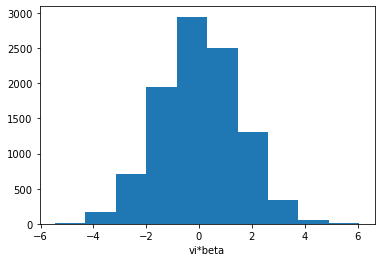

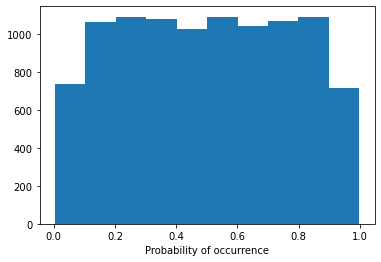

Training samples: 100
Testing samples: 100
Maximum AUC: 0.7304
[0 1 0 0 1 1 0 1 0 1]


In [13]:
# Data generation parameters
embedding_size = 100
vi_dim = 100
num_data = 10000
max_num_emb = 100
v = 0
seed = 1  # You can change the seed for different data

# Generate data
data_inf_len = generate_data(vi_dim=vi_dim, num_data=num_data, max_num_emb=max_num_emb, v=v, seed=seed,sample_cut=100,len_cut=100)
X_train, X_test, y_train, y_test, beta, beta0, maximum_auc, Vi, train_vi, test_vi, train_vib, test_vib = data_inf_len

print(f'Training samples: {len(X_train)}')
print(f'Testing samples: {len(X_test)}')
print(f'Maximum AUC: {maximum_auc:.4f}')
print(y_test[:10])

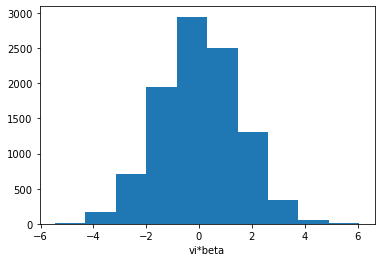

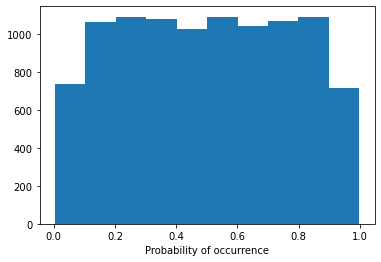

Training samples: 10
Testing samples: 10
Maximum AUC: 0.7304
[0 1 0 0 1 1 0 1 0 1]


In [17]:
# Data generation parameters
embedding_size = 100
vi_dim = 100
num_data = 10000
max_num_emb = 100
v = 0
seed = 1  # You can change the seed for different data

# Generate data
data_inf_len = generate_data(vi_dim=vi_dim, num_data=num_data, max_num_emb=max_num_emb, v=v, seed=seed,sample_cut=10,len_cut=1000)
X_train, X_test, y_train, y_test, beta, beta0, maximum_auc, Vi, train_vi, test_vi, train_vib, test_vib = data_inf_len

print(f'Training samples: {len(X_train)}')
print(f'Testing samples: {len(X_test)}')
print(f'Maximum AUC: {maximum_auc:.4f}')
print(y_test[:100])

# Data Preparation

# Deep ensemble

In [2]:
def deep_ensemble(num_data,
                  vi_dim,
                  max_seq_length,
                  v,
                  seed,
                  pooling,
                  deep_ensemble_learning_rate,
                  epochs,
                  n_training,
                  deep_ensemble_configs = [
                                            (1, 1),
                                            (1, 2),
                                            (1, 3),
                                            (2, 1),
                                            (4, 1)
                                        ],
                 ):
    # Deep Ensemble parameters
    # Define CLS token
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_inf_len = generate_data(vi_dim=vi_dim, num_data=100000, max_num_emb=100, v=v, seed=seed,length_vary=False,sample_cut=num_data,len_cut=max_seq_length)
    X_train, X_test, y_train, y_test, beta, beta0, maximum_auc, Vi, train_vi, test_vi, train_vib, test_vib = data_inf_len
    return y_test
    cls_token = np.random.randn(1, vi_dim) + 0

    # Pad sequences
    padded_train_data = pad_sequences(X_train, max_seq_length, cls_token)
    padded_test_data = pad_sequences(X_test, max_seq_length, cls_token)
    print(f'Padded Training Data Shape: {padded_train_data.shape}')
    print(f'Padded Testing Data Shape: {padded_test_data.shape}')

    # Generate padding masks
    padding_masks_train = generate_padding_mask(padded_train_data)
    padding_masks_test = generate_padding_mask(padded_test_data)

    # Create datasets
    train_dataset = MyDataset(padded_train_data, y_train, padding_masks_train)
    val_dataset = MyDataset(padded_test_data, y_test, padding_masks_test)

    # Create DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    # Transformer configurations for Deep Ensemble

    deep_ensemble_result = []

    for heads, layers in deep_ensemble_configs:
        print(f"\nTraining Deep Ensemble models with {heads} heads and {layers} layers.")
        n_samples = len(y_test)
        predictions_df = pd.DataFrame(index=range(n_samples), columns=range(n_training))

        for i in tqdm(range(n_training), desc=f"Config {heads}h{layers}l"):
            print(f"\nTraining Model {i+1}/{n_training} for config {heads}h{layers}l.")

            # Initialize model
            model = TransformerWithPooling(
                embedding_size=vi_dim,
                nhead=heads,
                dim_feedforward=512,
                num_layers=layers,
                num_classes=2,
                pooling=pooling,
                dropout=0.1
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=deep_ensemble_learning_rate)
            criterion = nn.CrossEntropyLoss()
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
            early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path=f'best_model_{heads}h{layers}l_model{i}.pt')

            # Train the model
            trained_model = train_predict(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=epochs,
                scheduler=scheduler,
                early_stopping=early_stopping,
                device=device
            )

            # Evaluate the model
            all_probs = []
            trained_model.eval()
            with torch.no_grad():
                for batch in val_loader:
                    test_inputs, val_padding_mask, _ = batch
                    test_inputs = test_inputs.float().to(device)
                    val_padding_mask = val_padding_mask.to(device)

                    outputs = trained_model(test_inputs, src_key_padding_mask=val_padding_mask)
                    probs = F.softmax(outputs, dim=1)
                    all_probs.append(probs.cpu().numpy())

            probabilities = np.concatenate(all_probs)
            predictions_df[i] = probabilities[:, 1]
            predicted_classes = (probabilities[:, 1] >= 0.5).astype(int)
            accuracy = np.mean(predicted_classes == y_test)
            print(f"Model {i+1}/{n_training}, Test Accuracy: {accuracy:.4f}")

            # Clean up
            del model
            torch.cuda.empty_cache()

        deep_ensemble_result.append(predictions_df)
        # Save the DataFrame to a file
    model_dir = f'epi_model'
    os.makedirs(model_dir, exist_ok=True)
    predictions_path = os.path.join(model_dir, f'epi_{pooling}_ss{num_data}_sq{max_seq_length}.pkl')
    with open(predictions_path, 'wb') as f:
        pickle.dump(deep_ensemble_result, f)
    print(f"Predictions saved to {predictions_path}")
    return 


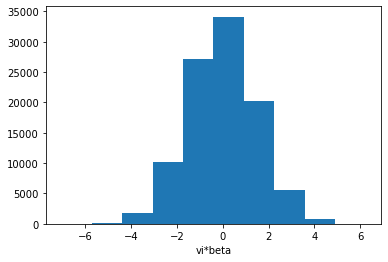

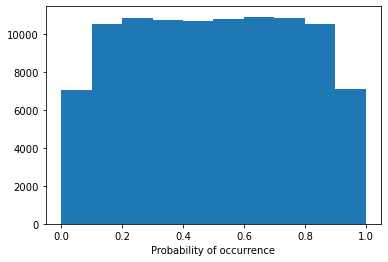

Deep Ensemble Result: [1 0 0 ... 0 1 1]


KeyboardInterrupt: 

In [22]:
sample_sizes=[10,100,1000,10000,100000]
seq_lengths=[1,2,3,4,5,10]

#for num_data,max_seq_length in [(10000,1),(10,100),(10,1000),(10000,100)]: # sample_size, seq_l
for num_data in sample_sizes:
    for max_seq_length in seq_lengths:
        
        vi_dim = 100  # Dimensionality of input vectors
        v = 0  # Vocabulary size or other model-dependent variable
        seed = 1  # Random seed for reproducibility
        pooling = "mean"  # Pooling method: "mean", "max", etc.
        deep_ensemble_learning_rate = 0.001  # Learning rate for Adam optimizer
        epochs = 10  # Number of training epochs
        n_training = 30  # Number of models per ensemble

        # Define ensemble configurations (heads, layers)
        deep_ensemble_configs = [
            (1, 3),# head layer
        ]

        # Call the function
        deep_ensemble_result = deep_ensemble(
            num_data=num_data,
            vi_dim=vi_dim,
            max_seq_length=max_seq_length,
            v=v,
            seed=seed,
            pooling=pooling,
            deep_ensemble_learning_rate=deep_ensemble_learning_rate,
            epochs=epochs,
            n_training=n_training,
            deep_ensemble_configs=deep_ensemble_configs
        )

        # Print the output
        print("Deep Ensemble Result:", deep_ensemble_result)


In [9]:
data_inf_len = generate_data(
        vi_dim=100, num_data=150000, max_num_emb=100, v=0, seed=42, length_vary=False, sample_cut=10000, var_e=0.5,len_cut=100
    )
X_train, X_test, y_train, y_test,beta, _, _, _, _, _, _, _ = data_inf_len

KeyboardInterrupt: 

## Transformer var=0.5

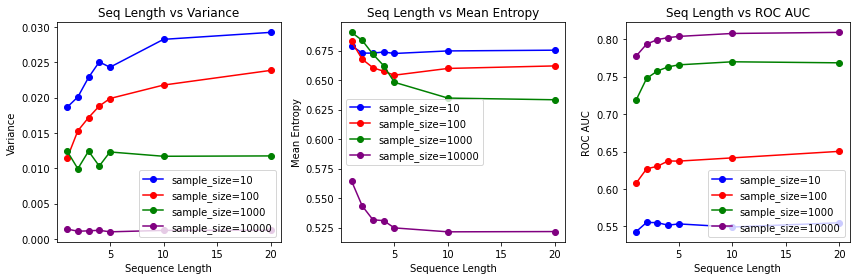

In [41]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

sample_sizes = [10, 100, 1000, 10000]
seq_lengths = [1, 2, 3, 4, 5, 10, 20]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  

colors = ['b', 'r', 'g', 'purple']

for idx, num_data in enumerate(sample_sizes):
    var_list = []      
    entropy_list = []  
    roc_auc_list = []  

    for max_seq_length in seq_lengths:
        filename = f"epi_model/tsf_mean_ss{num_data}_sq{max_seq_length}_var0.5.pkl"
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        pred_mean = np.mean(data[0], axis=1)
        pred_mean = np.array(pred_mean).flatten()
        
        y_true = y_test  
        fpr, tpr, _ = roc_curve(y_true, pred_mean)  
        roc_auc = auc(fpr, tpr)  
        roc_auc_list.append(roc_auc)

        var_val = np.mean(np.var(data[0], axis=1))
        var_list.append(var_val)
        
        eps = 1e-12
        entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
        mean_entropy = np.mean(entropy_samples)
        entropy_list.append(mean_entropy)
    
    axes[0].plot(seq_lengths, var_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")
    axes[1].plot(seq_lengths, entropy_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")
    axes[2].plot(seq_lengths, roc_auc_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")

axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Variance")
axes[0].set_title("Seq Length vs Variance")
axes[0].legend()

axes[1].set_xlabel("Sequence Length")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Seq Length vs Mean Entropy")
axes[1].legend()

axes[2].set_xlabel("Sequence Length")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Seq Length vs ROC AUC")
axes[2].legend()

plt.tight_layout()
plt.show()


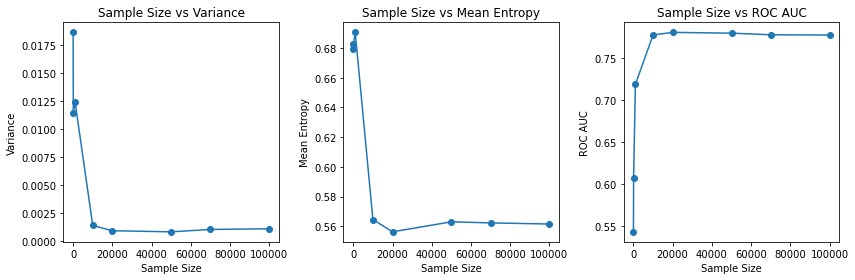

In [42]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

sample_sizes = [10, 100, 1000, 10000, 20000, 50000, 70000, 100000]
seq_length = 1

var_results = []
entropy_results = []
roc_auc_results = []  

for num_data in sample_sizes:
    filename = f"epi_model/tsf_mean_ss{num_data}_sq{seq_length}_var0.5.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    pred_mean = np.mean(data[0], axis=1)
    pred_mean = np.array(pred_mean).flatten()

    y_true = y_test  
    fpr, tpr, _ = roc_curve(y_true, pred_mean) 
    roc_auc = auc(fpr, tpr)  
    roc_auc_results.append(roc_auc)

    var_val = np.mean(np.var(data[0], axis=1))
    var_results.append(var_val)

    eps = 1e-12
    entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
    mean_entropy = np.mean(entropy_samples)
    entropy_results.append(mean_entropy)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(sample_sizes, var_results, marker='o')
axes[0].set_xlabel("Sample Size")
axes[0].set_ylabel("Variance")
axes[0].set_title("Sample Size vs Variance")

axes[1].plot(sample_sizes, entropy_results, marker='o')
axes[1].set_xlabel("Sample Size")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Sample Size vs Mean Entropy")

axes[2].plot(sample_sizes, roc_auc_results, marker='o')
axes[2].set_xlabel("Sample Size")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Sample Size vs ROC AUC")

plt.tight_layout()
plt.show()


## Transformer var=1

uncertainty vs sample_size

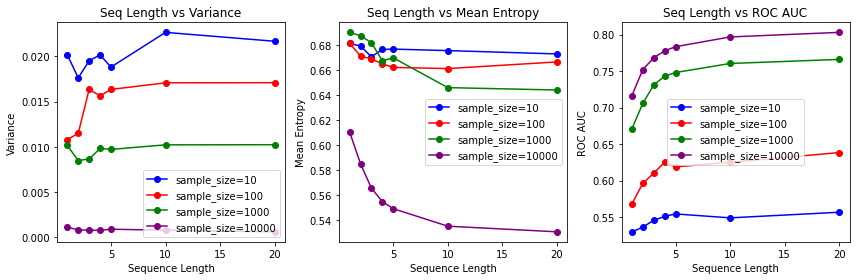

In [48]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

sample_sizes = [10, 100, 1000, 10000]
seq_lengths = [1, 2, 3, 4, 5, 10, 20]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  

colors = ['b', 'r', 'g', 'purple']

for idx, num_data in enumerate(sample_sizes):
    var_list = []      
    entropy_list = []  
    roc_auc_list = []  

    for max_seq_length in seq_lengths:
        filename = f"epi_model/tsf_mean_ss{num_data}_sq{max_seq_length}_var1.pkl"
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        pred_mean = np.mean(data[0], axis=1)
        pred_mean = np.array(pred_mean).flatten()
        
        y_true = y_test  
        fpr, tpr, _ = roc_curve(y_true, pred_mean)  
        roc_auc = auc(fpr, tpr)  
        roc_auc_list.append(roc_auc)

        var_val = np.mean(np.var(data[0], axis=1))
        var_list.append(var_val)
        
        eps = 1e-12
        entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
        mean_entropy = np.mean(entropy_samples)
        entropy_list.append(mean_entropy)
    
    axes[0].plot(seq_lengths, var_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")
    axes[1].plot(seq_lengths, entropy_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")
    axes[2].plot(seq_lengths, roc_auc_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")

axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Variance")
axes[0].set_title("Seq Length vs Variance")
axes[0].legend()

axes[1].set_xlabel("Sequence Length")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Seq Length vs Mean Entropy")
axes[1].legend()

axes[2].set_xlabel("Sequence Length")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Seq Length vs ROC AUC")
axes[2].legend()

plt.tight_layout()
plt.show()


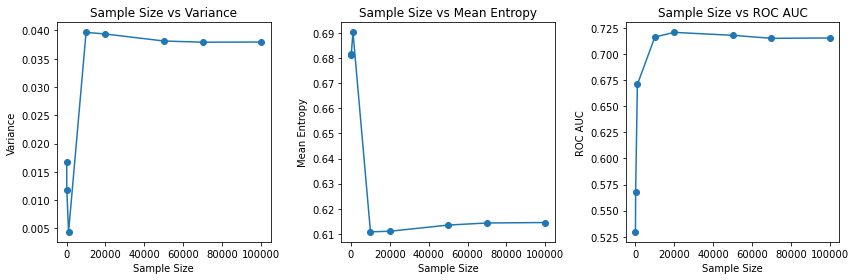

In [62]:
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define the sample sizes to be analyzed
sample_sizes = [10, 100, 1000, 10000, 20000, 50000, 70000, 100000]
seq_length = 1  # Fixed sequence length

# Lists to store computed variance, entropy, and ROC AUC results
var_results = []
entropy_results = []
roc_auc_results = []

# Iterate through each sample size
for num_data in sample_sizes:
    # Load the dataset from the corresponding pickle file
    filename = f"epi_model/tsf_mean_ss{num_data}_sq{seq_length}_var1.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    # Compute the mean prediction across different samples
    pred_mean = np.mean(data[0], axis=1)
    pred_mean = np.array(pred_mean).flatten()
    # Compute ROC AUC only if ground truth labels are available
    y_true = y_test  # Assuming y_true is stored in data[1]
    fpr, tpr, _ = roc_curve(y_true, pred_mean)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Compute AUC score
    roc_auc_results.append(roc_auc)


    # Compute variance of predictions
    var_val = np.mean(np.var(data, axis=1))
    var_results.append(var_val)

    # Compute entropy using binary cross-entropy formula
    eps = 1e-12
    entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
    mean_entropy = np.mean(entropy_samples)
    entropy_results.append(mean_entropy)

# Create subplots to visualize variance, entropy, and ROC AUC trends
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot variance vs. sample size
axes[0].plot(sample_sizes, var_results, marker='o')
axes[0].set_xlabel("Sample Size")
axes[0].set_ylabel("Variance")
axes[0].set_title("Sample Size vs Variance")

# Plot mean entropy vs. sample size
axes[1].plot(sample_sizes, entropy_results, marker='o')
axes[1].set_xlabel("Sample Size")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Sample Size vs Mean Entropy")

# Plot ROC AUC vs. sample size
axes[2].plot(sample_sizes, roc_auc_results, marker='o')
axes[2].set_xlabel("Sample Size")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Sample Size vs ROC AUC")

# Adjust layout for better readability
plt.tight_layout()
plt.show()


Var 2

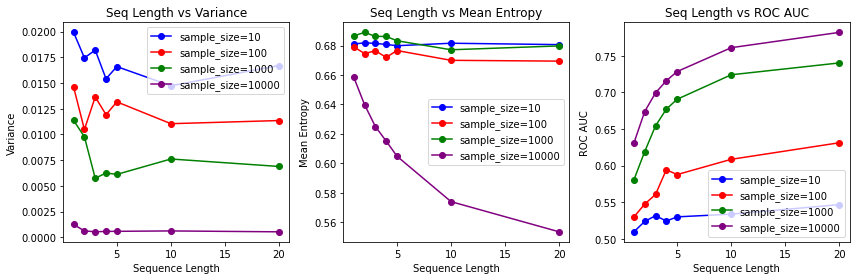

In [67]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

sample_sizes = [10, 100, 1000, 10000]
seq_lengths = [1, 2, 3, 4, 5, 10, 20]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  

colors = ['b', 'r', 'g', 'purple']

for idx, num_data in enumerate(sample_sizes):
    var_list = []      
    entropy_list = []  
    roc_auc_list = []  

    for max_seq_length in seq_lengths:
        filename = f"epi_model/tsf_mean_ss{num_data}_sq{max_seq_length}_var2.pkl"
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        pred_mean = np.mean(data[0], axis=1)
        pred_mean = np.array(pred_mean).flatten()
        
        y_true = y_test  
        fpr, tpr, _ = roc_curve(y_true, pred_mean)  
        roc_auc = auc(fpr, tpr)  
        roc_auc_list.append(roc_auc)

        var_val = np.mean(np.var(data[0], axis=1))
        var_list.append(var_val)
        
        eps = 1e-12
        entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
        mean_entropy = np.mean(entropy_samples)
        entropy_list.append(mean_entropy)
    
    axes[0].plot(seq_lengths, var_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")
    axes[1].plot(seq_lengths, entropy_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")
    axes[2].plot(seq_lengths, roc_auc_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")

axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Variance")
axes[0].set_title("Seq Length vs Variance")
axes[0].legend()

axes[1].set_xlabel("Sequence Length")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Seq Length vs Mean Entropy")
axes[1].legend()

axes[2].set_xlabel("Sequence Length")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Seq Length vs ROC AUC")
axes[2].legend()

plt.tight_layout()
plt.show()


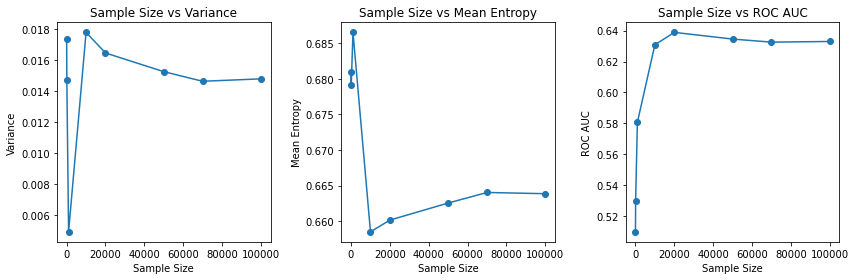

In [63]:
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define the sample sizes to be analyzed
sample_sizes = [10, 100, 1000, 10000, 20000, 50000, 70000, 100000]
seq_length = 1  # Fixed sequence length

# Lists to store computed variance, entropy, and ROC AUC results
var_results = []
entropy_results = []
roc_auc_results = []

# Iterate through each sample size
for num_data in sample_sizes:
    # Load the dataset from the corresponding pickle file
    filename = f"epi_model/tsf_mean_ss{num_data}_sq{seq_length}_var2.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    # Compute the mean prediction across different samples
    pred_mean = np.mean(data[0], axis=1)
    pred_mean = np.array(pred_mean).flatten()
    # Compute ROC AUC only if ground truth labels are available
    y_true = y_test  # Assuming y_true is stored in data[1]
    fpr, tpr, _ = roc_curve(y_true, pred_mean)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Compute AUC score
    roc_auc_results.append(roc_auc)

    # Compute variance of predictions
    var_val = np.mean(np.var(data, axis=1))
    var_results.append(var_val)

    # Compute entropy using binary cross-entropy formula
    eps = 1e-12
    entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
    mean_entropy = np.mean(entropy_samples)
    entropy_results.append(mean_entropy)

# Create subplots to visualize variance, entropy, and ROC AUC trends
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot variance vs. sample size
axes[0].plot(sample_sizes, var_results, marker='o')
axes[0].set_xlabel("Sample Size")
axes[0].set_ylabel("Variance")
axes[0].set_title("Sample Size vs Variance")

# Plot mean entropy vs. sample size
axes[1].plot(sample_sizes, entropy_results, marker='o')
axes[1].set_xlabel("Sample Size")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Sample Size vs Mean Entropy")

# Plot ROC AUC vs. sample size
axes[2].plot(sample_sizes, roc_auc_results, marker='o')
axes[2].set_xlabel("Sample Size")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Sample Size vs ROC AUC")

# Adjust layout for better readability
plt.tight_layout()
plt.show()


## logistic regression (var=0.5)

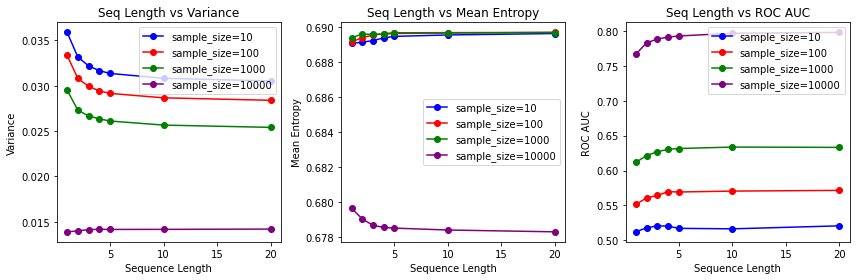

In [64]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define sample sizes and sequence lengths
sample_sizes = [10, 100, 1000, 10000]
seq_lengths = [1, 2, 3, 4, 5, 10, 20]

# Create subplots: one for variance, one for entropy, and one for ROC AUC
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Define colors for different sample sizes
colors = ['b', 'r', 'g', 'purple']

# Iterate over each sample size
for idx, num_data in enumerate(sample_sizes):
    var_list = []       # Store variance values
    entropy_list = []   # Store entropy values
    roc_auc_list = []   # Store ROC AUC values

    # Iterate over each sequence length
    for max_seq_length in seq_lengths:
        # Load the dataset from the corresponding pickle file
        filename = f"epi_model_test/epi_mean_ss{num_data}_sq{max_seq_length}_var0.5.pkl"
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        # Compute the mean prediction across different samples
        pred_mean = np.mean(data[0], axis=1)
        pred_mean = np.array(pred_mean).flatten()
        
        # Compute ROC AUC only if ground truth labels are available
        y_true = y_test  # Assuming y_true is stored in data[1]
        fpr, tpr, _ = roc_curve(y_true, pred_mean)  # Compute ROC curve
        roc_auc = auc(fpr, tpr)  # Compute AUC score
        roc_auc_list.append(roc_auc)

        # Compute variance of predictions
        var_val = np.mean(np.var(data, axis=1))
        var_list.append(var_val)

        # Compute entropy using binary cross-entropy formula
        eps = 1e-12
        entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
        mean_entropy = np.mean(entropy_samples)
        entropy_list.append(mean_entropy)

    # Plot variance vs. sequence length
    axes[0].plot(seq_lengths, var_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")
    
    # Plot mean entropy vs. sequence length
    axes[1].plot(seq_lengths, entropy_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")

    # Plot ROC AUC vs. sequence length
    axes[2].plot(seq_lengths, roc_auc_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")

# Set labels and titles for each subplot
axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Variance")
axes[0].set_title("Seq Length vs Variance")
axes[0].legend()

axes[1].set_xlabel("Sequence Length")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Seq Length vs Mean Entropy")
axes[1].legend()

axes[2].set_xlabel("Sequence Length")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Seq Length vs ROC AUC")
axes[2].legend()

# Adjust layout for better readability
plt.tight_layout()
plt.show()


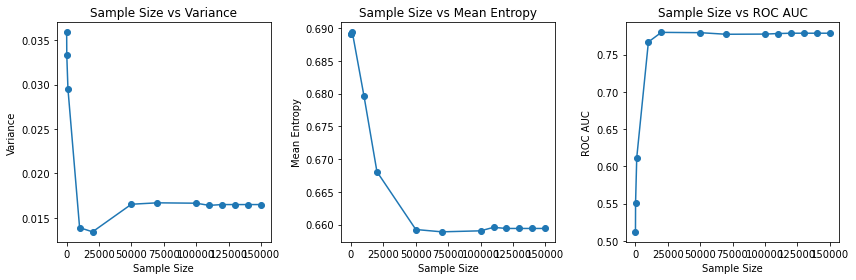

In [65]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define sample sizes and fixed sequence length
sample_sizes = [10, 100, 1000, 10000, 20000, 50000, 70000, 100000, 
                110000, 120000, 130000,140000, 150000]
max_seq_length = 1  # Fixed sequence length

# Lists to store computed variance, entropy, and ROC AUC results
var_results = []
entropy_results = []
roc_auc_results = []

# Iterate through each sample size
for num_data in sample_sizes:
    # Load the dataset from the corresponding pickle file
    filename = f"epi_model_test/epi_mean_ss{num_data}_sq{max_seq_length}_var0.5.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    # Compute the mean prediction across different samples
    pred_mean = np.mean(data[0], axis=1)
    pred_mean = np.array(pred_mean).flatten()

    # Compute ROC AUC only if ground truth labels are available
    y_true = y_test  # Assuming y_true is stored in data[1]
    fpr, tpr, _ = roc_curve(y_true, pred_mean)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Compute AUC score
    roc_auc_results.append(roc_auc)

    # Compute variance of predictions
    var_val = np.mean(np.var(data, axis=1))
    var_results.append(var_val)

    # Compute entropy using binary cross-entropy formula
    eps = 1e-12
    entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
    mean_entropy = np.mean(entropy_samples)
    entropy_results.append(mean_entropy)

# Create subplots to visualize variance, entropy, and ROC AUC trends
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot variance vs. sample size
axes[0].plot(sample_sizes, var_results, marker='o')
axes[0].set_xlabel("Sample Size")
axes[0].set_ylabel("Variance")
axes[0].set_title("Sample Size vs Variance")

# Plot mean entropy vs. sample size
axes[1].plot(sample_sizes, entropy_results, marker='o')
axes[1].set_xlabel("Sample Size")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Sample Size vs Mean Entropy")

# Plot ROC AUC vs. sample size
axes[2].plot(sample_sizes, roc_auc_results, marker='o')
axes[2].set_xlabel("Sample Size")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Sample Size vs ROC AUC")

# Adjust layout for better readability
plt.tight_layout()
plt.show()


## Logistic regression result (var=1)

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define sample sizes and sequence lengths
sample_sizes = [10, 100, 1000, 10000]
seq_lengths = [1, 2, 3, 4, 5, 10, 20]

# Create subplots: one for variance, one for entropy, and one for ROC AUC
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Define colors for different sample sizes
colors = ['b', 'r', 'g', 'purple']

# Iterate over each sample size
for idx, num_data in enumerate(sample_sizes):
    var_list = []       # Store variance values
    entropy_list = []   # Store entropy values
    roc_auc_list = []   # Store ROC AUC values

    # Iterate over each sequence length
    for max_seq_length in seq_lengths:
        # Load the dataset from the corresponding pickle file
        filename = f"epi_model_test/epi_mean_ss{num_data}_sq{max_seq_length}_var1.pkl"
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        # Compute the mean prediction across different samples
        pred_mean = np.mean(data[0], axis=1)
        pred_mean = np.array(pred_mean).flatten()
        
        # Compute ROC AUC only if ground truth labels are available
        y_true = y_test  # Assuming y_true is stored in data[1]
        fpr, tpr, _ = roc_curve(y_true, pred_mean)  # Compute ROC curve
        roc_auc = auc(fpr, tpr)  # Compute AUC score
        roc_auc_list.append(roc_auc)

        # Compute variance of predictions
        var_val = np.mean(np.var(data, axis=1))
        var_list.append(var_val)

        # Compute entropy using binary cross-entropy formula
        eps = 1e-12
        entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
        mean_entropy = np.mean(entropy_samples)
        entropy_list.append(mean_entropy)

    # Plot variance vs. sequence length
    axes[0].plot(seq_lengths, var_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")
    
    # Plot mean entropy vs. sequence length
    axes[1].plot(seq_lengths, entropy_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")

    # Plot ROC AUC vs. sequence length
    axes[2].plot(seq_lengths, roc_auc_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")

# Set labels and titles for each subplot
axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Variance")
axes[0].set_title("Seq Length vs Variance")
axes[0].legend()

axes[1].set_xlabel("Sequence Length")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Seq Length vs Mean Entropy")
axes[1].legend()

axes[2].set_xlabel("Sequence Length")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Seq Length vs ROC AUC")
axes[2].legend()

# Adjust layout for better readability
plt.tight_layout()
plt.show()


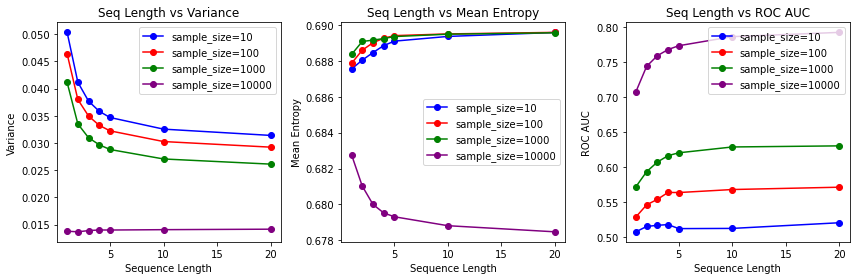

In [52]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define sample sizes and sequence lengths
sample_sizes = [10, 100, 1000, 10000]
seq_lengths = [1, 2, 3, 4, 5, 10, 20]

# Create subplots: one for variance, one for entropy, and one for ROC AUC
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Define colors for different sample sizes
colors = ['b', 'r', 'g', 'purple']

# Iterate over each sample size
for idx, num_data in enumerate(sample_sizes):
    var_list = []       # Store variance values
    entropy_list = []   # Store entropy values
    roc_auc_list = []   # Store ROC AUC values

    # Iterate over each sequence length
    for max_seq_length in seq_lengths:
        # Load the dataset from the corresponding pickle file
        filename = f"epi_model_test/epi_mean_ss{num_data}_sq{max_seq_length}_var1.pkl"
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        # Compute the mean prediction across different samples
        pred_mean = np.mean(data[0], axis=1)
        pred_mean = np.array(pred_mean).flatten()
        
        # Compute ROC AUC only if ground truth labels are available
        y_true = y_test  # Assuming y_true is stored in data[1]
        fpr, tpr, _ = roc_curve(y_true, pred_mean)  # Compute ROC curve
        roc_auc = auc(fpr, tpr)  # Compute AUC score
        roc_auc_list.append(roc_auc)

        # Compute variance of predictions
        var_val = np.mean(np.var(data, axis=1))
        var_list.append(var_val)

        # Compute entropy using binary cross-entropy formula
        eps = 1e-12
        entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
        mean_entropy = np.mean(entropy_samples)
        entropy_list.append(mean_entropy)

    # Plot variance vs. sequence length
    axes[0].plot(seq_lengths, var_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")
    
    # Plot mean entropy vs. sequence length
    axes[1].plot(seq_lengths, entropy_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")

    # Plot ROC AUC vs. sequence length
    axes[2].plot(seq_lengths, roc_auc_list, marker='o', color=colors[idx], label=f"sample_size={num_data}")

# Set labels and titles for each subplot
axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Variance")
axes[0].set_title("Seq Length vs Variance")
axes[0].legend()

axes[1].set_xlabel("Sequence Length")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Seq Length vs Mean Entropy")
axes[1].legend()

axes[2].set_xlabel("Sequence Length")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Seq Length vs ROC AUC")
axes[2].legend()

# Adjust layout for better readability
plt.tight_layout()
plt.show()


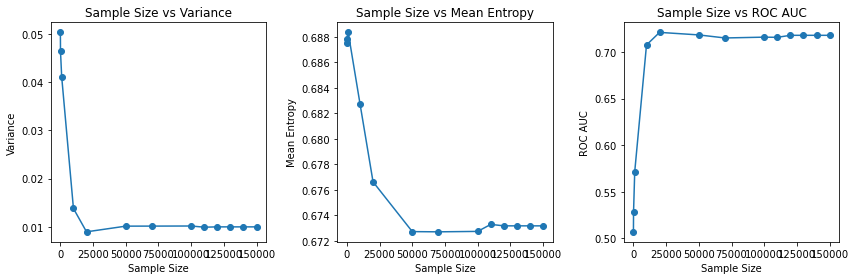

In [66]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define sample sizes and fixed sequence length
sample_sizes = [10, 100, 1000, 10000, 20000, 50000, 70000, 100000, 
                110000, 120000, 130000, 140000, 150000]
max_seq_length = 1  # Fixed sequence length

# Lists to store computed variance, entropy, and ROC AUC results
var_results = []
entropy_results = []
roc_auc_results = []

# Iterate through each sample size
for num_data in sample_sizes:
    # Load the dataset from the corresponding pickle file
    filename = f"epi_model_test/epi_mean_ss{num_data}_sq{max_seq_length}_var1.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    # Compute the mean prediction across different samples
    pred_mean = np.mean(data[0], axis=1)
    pred_mean = np.array(pred_mean).flatten()

    # Compute ROC AUC only if ground truth labels are available
    y_true = y_test  # Assuming y_true is stored in data[1]
    fpr, tpr, _ = roc_curve(y_true, pred_mean)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Compute AUC score
    roc_auc_results.append(roc_auc)

    # Compute variance of predictions
    var_val = np.mean(np.var(data, axis=1))
    var_results.append(var_val)

    # Compute entropy using binary cross-entropy formula
    eps = 1e-12
    entropy_samples = -(pred_mean * np.log(pred_mean + eps) + (1 - pred_mean) * np.log(1 - pred_mean + eps))
    mean_entropy = np.mean(entropy_samples)
    entropy_results.append(mean_entropy)

# Create subplots to visualize variance, entropy, and ROC AUC trends
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot variance vs. sample size
axes[0].plot(sample_sizes, var_results, marker='o')
axes[0].set_xlabel("Sample Size")
axes[0].set_ylabel("Variance")
axes[0].set_title("Sample Size vs Variance")

# Plot mean entropy vs. sample size
axes[1].plot(sample_sizes, entropy_results, marker='o')
axes[1].set_xlabel("Sample Size")
axes[1].set_ylabel("Mean Entropy")
axes[1].set_title("Sample Size vs Mean Entropy")

# Plot ROC AUC vs. sample size
axes[2].plot(sample_sizes, roc_auc_results, marker='o')
axes[2].set_xlabel("Sample Size")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("Sample Size vs ROC AUC")

# Adjust layout for better readability
plt.tight_layout()
plt.show()


## Infinite sample size

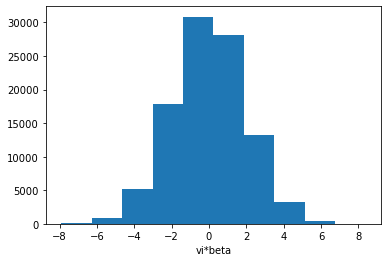

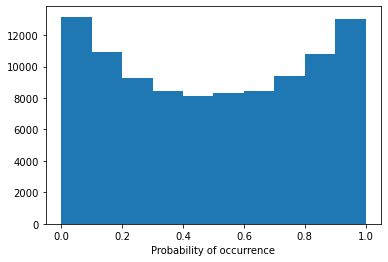

In [2]:
data_inf_len = generate_data(
        vi_dim=20, num_data=100000, max_num_emb=100, v=0, seed=42, length_vary=False, sample_cut=10000, var_e=0.5,len_cut=100,beta_var=0.4
    )
X_train, X_test, y_train, y_test, beta, beta0, _, _, _, _, _, _ = data_inf_len

## P(V|E,D)

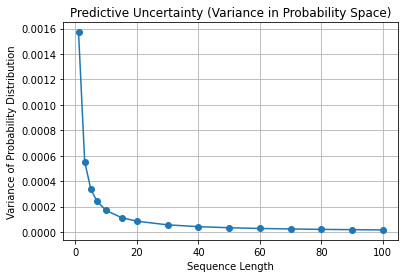

In [24]:
import numpy as np
from scipy.special import expit  # sigmoid

var_e = 0.25
var_list = []

n_samples = 1000  
seq_lengths = [1, 3, 5, 7, 10, 15, 20,30,40,50,60,70,80,90,100]
for sql in seq_lengths:
    vi_miu_std = [np.sum(i[:sql], axis=0) / (sql + var_e**2) for i in X_test]

    vi_var_std = [var_e**2 / (float(sql) + var_e**2) for _ in X_test]

    sum_beta_square = sum(beta[i]**2 for i in range(20))

    vib_var_std = [sum_beta_square * v for v in vi_var_std]
    vib_miu_std = [x @ beta - beta0 for x in vi_miu_std]

    prob_var_list = []
    for mu, var in zip(vib_miu_std, vib_var_std):
        logodds_samples = np.random.normal(mu, np.sqrt(var), n_samples)
        prob_samples = expit(logodds_samples)  
        prob_var = np.var(prob_samples)
        prob_var_list.append(prob_var)

    var_list.append(np.mean(prob_var_list))


plt.plot(seq_lengths, var_list, marker='o')
plt.xlabel("Sequence Length")
plt.ylabel("Variance of Probability Distribution")
plt.title("Predictive Uncertainty (Variance in Probability Space)")
plt.grid(True)
plt.show()


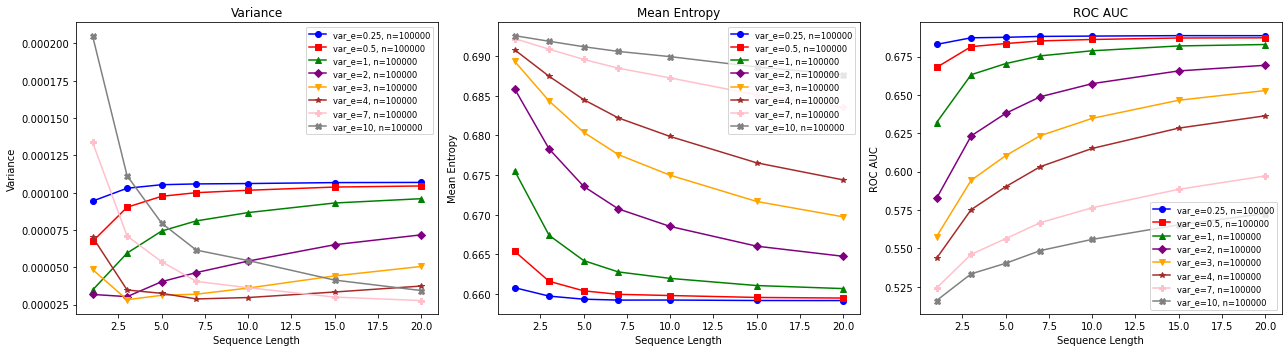

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import roc_curve, auc

# Simulated y_test for demonstration (Replace this with your actual y_test)
np.random.seed(42)

var_e_list = [0.25, 0.5, 1, 2, 3, 4, 7, 10]
combo_seql_ss = [([1, 3, 5, 7, 10, 15, 20], [100000])]

# Define markers and colors for variety
colors = ['b', 'r', 'g', 'purple', 'orange', 'brown', 'pink', 'gray']
markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X']

# Create one figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx_ve, var_e in enumerate(var_e_list):
    for idx, (seq_lengths, sample_sizes) in enumerate(combo_seql_ss):
        for num_data in sample_sizes:
            var_list = []
            entropy_list = []
            roc_auc_list = []

            for max_seq_length in seq_lengths:
                filename = f"epi_model_limitation/epi_mean_ss{num_data}_sq{max_seq_length}_var{var_e}.pkl"
                try:
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)
                except FileNotFoundError:
                    continue

                pred_mean = np.mean(data[0], axis=1)
                y_true = y_test

                fpr, tpr, _ = roc_curve(y_true, pred_mean)
                roc_auc = auc(fpr, tpr)
                roc_auc_list.append(roc_auc)

                var_val = np.mean(np.var(data[0], axis=1))
                var_list.append(var_val)

                eps = 1e-12
                entropy_samples = -(pred_mean * np.log(pred_mean + eps) +
                                    (1 - pred_mean) * np.log(1 - pred_mean + eps))
                mean_entropy = np.mean(entropy_samples)
                entropy_list.append(mean_entropy)

            label = f"var_e={var_e}, n={num_data}"
            color = colors[idx_ve % len(colors)]
            marker = markers[idx_ve % len(markers)]

            axes[0].plot(seq_lengths[:len(var_list)], var_list, marker=marker, color=color, label=label)
            axes[1].plot(seq_lengths[:len(entropy_list)], entropy_list, marker=marker, color=color, label=label)
            axes[2].plot(seq_lengths[:len(roc_auc_list)], roc_auc_list, marker=marker, color=color, label=label)

# Set labels and titles for the shared plot
titles = ["Variance", "Mean Entropy", "ROC AUC"]
ylabels = ["Variance", "Mean Entropy", "ROC AUC"]
for i in range(3):
    axes[i].set_xlabel("Sequence Length")
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_title(titles[i])
    axes[i].legend(fontsize='small')

plt.tight_layout()
plt.show()


## Infinite sequence length

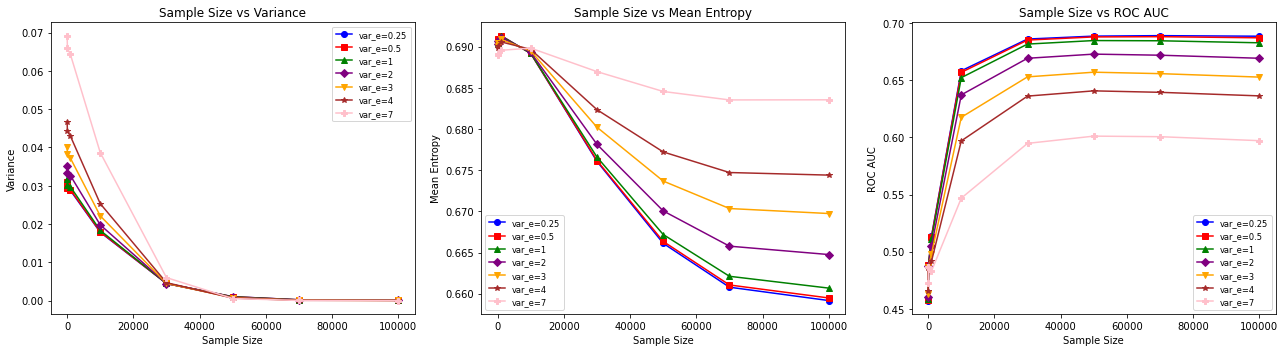

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import roc_curve, auc

# Simulated y_test for demonstration (Replace this with your actual y_test)
np.random.seed(42)

var_e_list = [0.25, 0.5, 1, 2, 3, 4, 7]
sample_sizes = [10,100,1000,10000,30000,50000,70000,100000]
max_seq_length = 20

# Define colors and markers
colors = ['b', 'r', 'g', 'purple', 'orange', 'brown', 'pink', 'gray']
markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X']

# Create one figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx_ve, var_e in enumerate(var_e_list):
    var_results = []
    entropy_results = []
    roc_auc_results = []
    valid_sample_sizes = []

    for num_data in sample_sizes:
        filename = f"epi_model_limitation/epi_mean_ss{num_data}_sq{max_seq_length}_var{var_e}.pkl"
        try:
            with open(filename, 'rb') as f:
                data = pickle.load(f)
        except FileNotFoundError:
            continue

        pred_mean = np.mean(data[0], axis=1)
        y_true = y_test[:len(pred_mean)]

        fpr, tpr, _ = roc_curve(y_true, pred_mean)
        roc_auc = auc(fpr, tpr)
        roc_auc_results.append(roc_auc)

        var_val = np.mean(np.var(data[0], axis=1))
        var_results.append(var_val)

        eps = 1e-12
        entropy_samples = -(pred_mean * np.log(pred_mean + eps) +
                            (1 - pred_mean) * np.log(1 - pred_mean + eps))
        mean_entropy = np.mean(entropy_samples)
        entropy_results.append(mean_entropy)

        valid_sample_sizes.append(num_data)

    label = f"var_e={var_e}"
    color = colors[idx_ve % len(colors)]
    marker = markers[idx_ve % len(markers)]

    axes[0].plot(valid_sample_sizes, var_results, marker=marker, color=color, label=label)
    axes[1].plot(valid_sample_sizes, entropy_results, marker=marker, color=color, label=label)
    axes[2].plot(valid_sample_sizes, roc_auc_results, marker=marker, color=color, label=label)

# Set labels and titles
titles = ["Sample Size vs Variance", "Sample Size vs Mean Entropy", "Sample Size vs ROC AUC"]
ylabels = ["Variance", "Mean Entropy", "ROC AUC"]
for i in range(3):
    axes[i].set_xlabel("Sample Size")
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_title(titles[i])
    axes[i].legend(fontsize='small')

plt.tight_layout()
plt.show()


# TSF

### mean

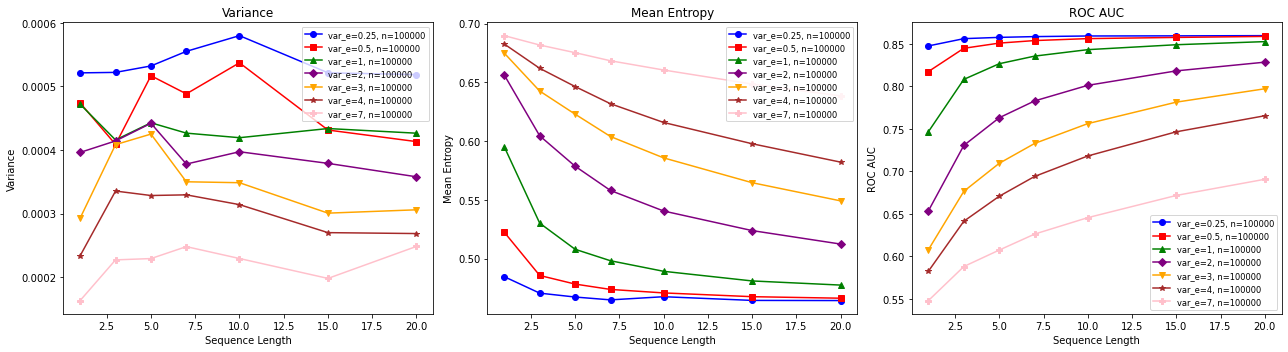

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import roc_curve, auc

beta_var = 0.4
pooling = "cls"
var_e_list = [0.25, 0.5, 1, 2, 3, 4, 7]
combo_seql_ss = [([1, 3, 5, 7, 10, 15, 20], [100000])]

colors = ['b', 'r', 'g', 'purple', 'orange', 'brown', 'pink', 'gray']
markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx_ve, var_e in enumerate(var_e_list):
    for idx, (seq_lengths, sample_sizes) in enumerate(combo_seql_ss):
        for num_data in sample_sizes:
            var_list = []
            entropy_list = []
            roc_auc_list = []

            for max_seq_length in seq_lengths:
                filename = f"epi_model_tsf/tsf_mean_ss{num_data}_sq{max_seq_length}_var{var_e}_beta_var{beta_var}.pkl"
                try:
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)
                except FileNotFoundError:
                    print(f"not_found: {filename}")
                    continue

                pred_array = np.array(data[0]).astype(np.float32)
                pred_mean = np.mean(pred_array, axis=1)

                try:
                    fpr, tpr, _ = roc_curve(y_test, pred_mean)
                    roc_auc = auc(fpr, tpr)
                except:
                    roc_auc = np.nan
                roc_auc_list.append(roc_auc)

                var_val = np.mean(np.var(pred_array, axis=1))
                var_list.append(var_val)

                eps = 1e-12
                entropies = -(pred_array * np.log(pred_array + eps) + (1 - pred_array) * np.log(1 - pred_array + eps))
                sample_entropy = np.mean(entropies, axis=1)
                mean_entropy = np.mean(sample_entropy)
                entropy_list.append(mean_entropy)

            label = f"var_e={var_e}, n={num_data}"
            color = colors[idx_ve % len(colors)]
            marker = markers[idx_ve % len(markers)]

            axes[0].plot(seq_lengths[:len(var_list)], var_list, marker=marker, color=color, label=label)
            axes[1].plot(seq_lengths[:len(entropy_list)], entropy_list, marker=marker, color=color, label=label)
            axes[2].plot(seq_lengths[:len(roc_auc_list)], roc_auc_list, marker=marker, color=color, label=label)

titles = ["Variance", "Mean Entropy", "ROC AUC"]
ylabels = ["Variance", "Mean Entropy", "ROC AUC"]
for i in range(3):
    axes[i].set_xlabel("Sequence Length")
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_title(titles[i])
    axes[i].legend(fontsize='small')

plt.tight_layout()
plt.show()


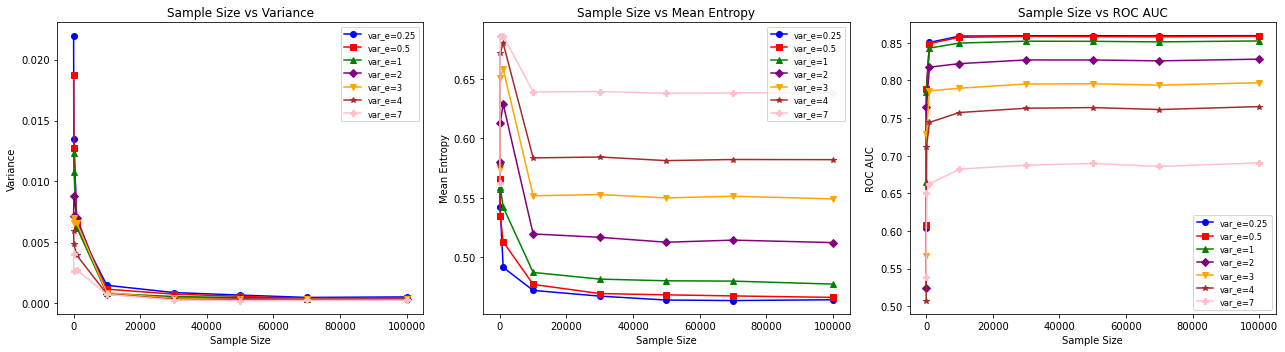

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import roc_curve, auc

np.random.seed(42)

var_e_list = [0.25, 0.5, 1, 2, 3, 4, 7]
sample_sizes = [10, 100, 1000, 10000, 30000, 50000, 70000, 100000]
max_seq_length = 20

colors = ['b', 'r', 'g', 'purple', 'orange', 'brown', 'pink', 'gray']
markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx_ve, var_e in enumerate(var_e_list):
    var_results = []
    entropy_results = []
    roc_auc_results = []
    valid_sample_sizes = []

    for num_data in sample_sizes:
        filename = f"epi_model_tsf/tsf_mean_ss{num_data}_sq{max_seq_length}_var{var_e}_beta_var0.4.pkl"
        try:
            with open(filename, 'rb') as f:
                data = pickle.load(f)
        except FileNotFoundError:
            continue

        pred_array = np.array(data[0]).astype(np.float32)
        pred_mean = np.mean(pred_array, axis=1)
        y_true = y_test[:len(pred_mean)]

        try:
            fpr, tpr, _ = roc_curve(y_true, pred_mean)
            roc_auc = auc(fpr, tpr)
        except:
            roc_auc = np.nan
        roc_auc_results.append(roc_auc)

        var_val = np.mean(np.var(pred_array, axis=1))
        var_results.append(var_val)

        eps = 1e-12
        entropies = -(pred_array * np.log(pred_array + eps) + (1 - pred_array) * np.log(1 - pred_array + eps))
        sample_entropy = np.mean(entropies, axis=1)
        mean_entropy = np.mean(sample_entropy)
        entropy_results.append(mean_entropy)

        valid_sample_sizes.append(num_data)

    label = f"var_e={var_e}"
    color = colors[idx_ve % len(colors)]
    marker = markers[idx_ve % len(markers)]

    axes[0].plot(valid_sample_sizes, var_results, marker=marker, color=color, label=label)
    axes[1].plot(valid_sample_sizes, entropy_results, marker=marker, color=color, label=label)
    axes[2].plot(valid_sample_sizes, roc_auc_results, marker=marker, color=color, label=label)

titles = ["Sample Size vs Variance", "Sample Size vs Mean Entropy", "Sample Size vs ROC AUC"]
ylabels = ["Variance", "Mean Entropy", "ROC AUC"]
for i in range(3):
    axes[i].set_xlabel("Sample Size")
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_title(titles[i])
    axes[i].legend(fontsize='small')

plt.tight_layout()
plt.show()


### CLS

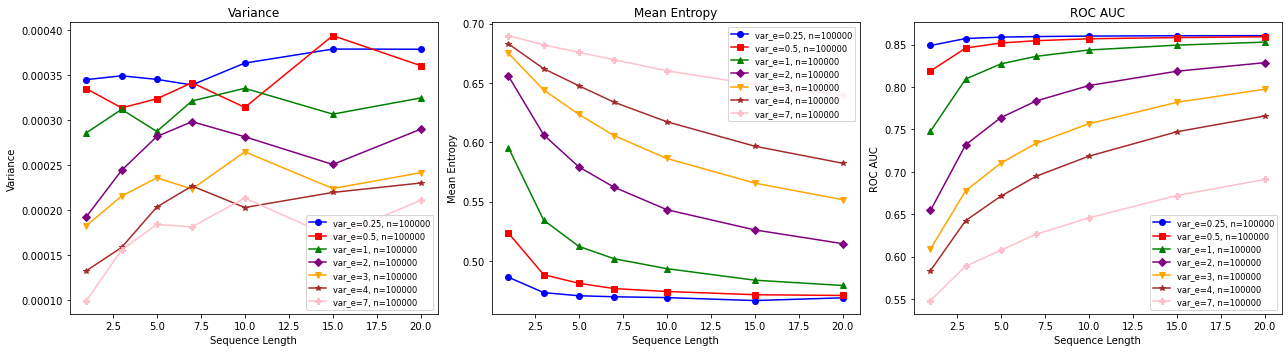

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import roc_curve, auc

beta_var = 0.4
pooling = "cls"
var_e_list = [0.25, 0.5, 1, 2, 3, 4, 7]
combo_seql_ss = [([1, 3, 5, 7, 10, 15, 20], [100000])]

colors = ['b', 'r', 'g', 'purple', 'orange', 'brown', 'pink', 'gray']
markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx_ve, var_e in enumerate(var_e_list):
    for idx, (seq_lengths, sample_sizes) in enumerate(combo_seql_ss):
        for num_data in sample_sizes:
            var_list = []
            entropy_list = []
            roc_auc_list = []

            for max_seq_length in seq_lengths:
                filename = f"epi_model_tsf/tsf_cls_ss{num_data}_sq{max_seq_length}_var{var_e}_beta_var{beta_var}.pkl"
                try:
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)
                except FileNotFoundError:
                    print(f"not_found: {filename}")
                    continue

                pred_array = np.array(data[0]).astype(np.float32)
                pred_mean = np.mean(pred_array, axis=1)

                try:
                    fpr, tpr, _ = roc_curve(y_test, pred_mean)
                    roc_auc = auc(fpr, tpr)
                except:
                    roc_auc = np.nan
                roc_auc_list.append(roc_auc)

                var_val = np.mean(np.var(pred_array, axis=1))
                var_list.append(var_val)

                eps = 1e-12
                entropies = -(pred_array * np.log(pred_array + eps) + (1 - pred_array) * np.log(1 - pred_array + eps))
                sample_entropy = np.mean(entropies, axis=1)
                mean_entropy = np.mean(sample_entropy)
                entropy_list.append(mean_entropy)

            label = f"var_e={var_e}, n={num_data}"
            color = colors[idx_ve % len(colors)]
            marker = markers[idx_ve % len(markers)]

            axes[0].plot(seq_lengths[:len(var_list)], var_list, marker=marker, color=color, label=label)
            axes[1].plot(seq_lengths[:len(entropy_list)], entropy_list, marker=marker, color=color, label=label)
            axes[2].plot(seq_lengths[:len(roc_auc_list)], roc_auc_list, marker=marker, color=color, label=label)

titles = ["Variance", "Mean Entropy", "ROC AUC"]
ylabels = ["Variance", "Mean Entropy", "ROC AUC"]
for i in range(3):
    axes[i].set_xlabel("Sequence Length")
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_title(titles[i])
    axes[i].legend(fontsize='small')

plt.tight_layout()
plt.show()


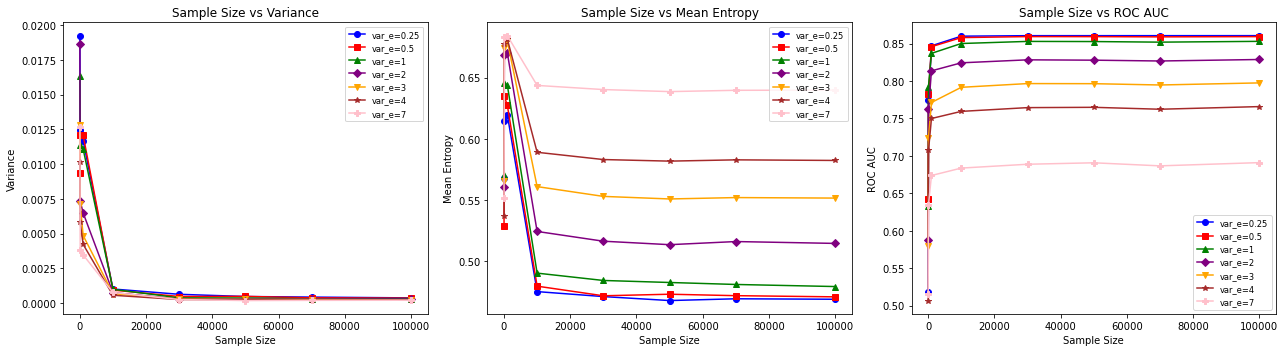

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import roc_curve, auc

np.random.seed(42)

var_e_list = [0.25, 0.5, 1, 2, 3, 4, 7]
sample_sizes = [10, 100, 1000, 10000, 30000, 50000, 70000, 100000]
max_seq_length = 20

colors = ['b', 'r', 'g', 'purple', 'orange', 'brown', 'pink', 'gray']
markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx_ve, var_e in enumerate(var_e_list):
    var_results = []
    entropy_results = []
    roc_auc_results = []
    valid_sample_sizes = []

    for num_data in sample_sizes:
        filename = f"epi_model_tsf/tsf_cls_ss{num_data}_sq{max_seq_length}_var{var_e}_beta_var0.4.pkl"
        try:
            with open(filename, 'rb') as f:
                data = pickle.load(f)
        except FileNotFoundError:
            continue

        pred_array = np.array(data[0]).astype(np.float32)
        pred_mean = np.mean(pred_array, axis=1)
        y_true = y_test[:len(pred_mean)]

        try:
            fpr, tpr, _ = roc_curve(y_true, pred_mean)
            roc_auc = auc(fpr, tpr)
        except:
            roc_auc = np.nan
        roc_auc_results.append(roc_auc)

        var_val = np.mean(np.var(pred_array, axis=1))
        var_results.append(var_val)

        eps = 1e-12
        entropies = -(pred_array * np.log(pred_array + eps) + (1 - pred_array) * np.log(1 - pred_array + eps))
        sample_entropy = np.mean(entropies, axis=1)
        mean_entropy = np.mean(sample_entropy)
        entropy_results.append(mean_entropy)

        valid_sample_sizes.append(num_data)

    label = f"var_e={var_e}"
    color = colors[idx_ve % len(colors)]
    marker = markers[idx_ve % len(markers)]

    axes[0].plot(valid_sample_sizes, var_results, marker=marker, color=color, label=label)
    axes[1].plot(valid_sample_sizes, entropy_results, marker=marker, color=color, label=label)
    axes[2].plot(valid_sample_sizes, roc_auc_results, marker=marker, color=color, label=label)

titles = ["Sample Size vs Variance", "Sample Size vs Mean Entropy", "Sample Size vs ROC AUC"]
ylabels = ["Variance", "Mean Entropy", "ROC AUC"]
for i in range(3):
    axes[i].set_xlabel("Sample Size")
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_title(titles[i])
    axes[i].legend(fontsize='small')

plt.tight_layout()
plt.show()


## OOD

<ipython-input-3-53019ee560ae>:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


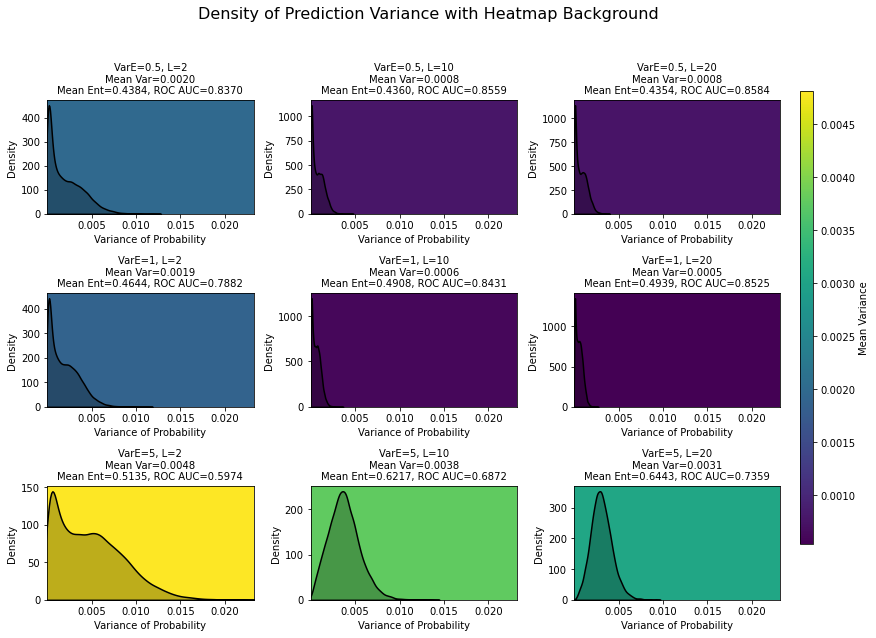

In [3]:
from sklearn.metrics import roc_auc_score
from scipy.stats import entropy as scipy_entropy
train_var_e = 1
test_var_es=[0.5,1,5]
train_l = 10
test_ls = [2,10,20]
num_data = 100000
beta_var = 0.4
pooling = "mean"
all_variances = {}  # (test_var_e, test_l) -> per-sample variances
mean_variances = np.zeros((len(test_var_es), len(test_ls)))  # for heatmap
mean_entropies = np.zeros((len(test_var_es), len(test_ls)))
mean_rocs = np.zeros((len(test_var_es), len(test_ls)))

for i, test_var_e in enumerate(test_var_es):
    for j, test_l in enumerate(test_ls):
        file_path = f'epi_model_tsf_ood/tsf_{pooling}_ss{num_data}_trainl{train_l}_testl{test_l}_train{train_var_e}_test{test_var_e}_beta_var{beta_var}.pkl'
        with open(file_path, 'rb') as f:
            pre_df = pickle.load(f)

        pred_array = pre_df.values.astype(np.float32)  
        sample_variances = np.var(pred_array, axis=1)
        all_variances[(test_var_e, test_l)] = sample_variances
        mean_variances[i, j] = np.mean(sample_variances)

        data_inf_len_test = generate_data(
            vi_dim=20, num_data=100000, max_num_emb=100,
            v=0, seed=42, length_vary=False,
            sample_cut=100000, len_cut=test_l,
            var_e=test_var_e, beta_var=beta_var,plot=False
        )
        _, X_test, _, y_test, *_ = data_inf_len_test

        mean_preds = pred_array.mean(axis=1)  

        eps = 1e-8  # 
        mean_entropy = -np.mean(mean_preds * np.log(mean_preds + eps) + (1 - mean_preds) * np.log(1 - mean_preds + eps))
        mean_entropies[i, j] = mean_entropy

        try:
            roc_auc = roc_auc_score(y_test, mean_preds)
        except ValueError:
            roc_auc = np.nan 
        mean_rocs[i, j] = roc_auc

import seaborn as sns
all_var_values = np.concatenate([v for v in all_variances.values()])
xmin, xmax = all_var_values.min(), all_var_values.max()

fig, axes = plt.subplots(len(test_var_es), len(test_ls), figsize=(4 * len(test_ls), 3 * len(test_var_es)))
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=np.min(mean_variances), vmax=np.max(mean_variances))

for i, test_var_e in enumerate(test_var_es):
    for j, test_l in enumerate(test_ls):
        ax = axes[i][j] if len(test_var_es) > 1 else axes[j]
        var_vec = all_variances[(test_var_e, test_l)]
        mean_var = mean_variances[i, j]
        mean_entropy = mean_entropies[i, j]
        mean_rocauc = mean_rocs[i, j]

        ax.set_facecolor(cmap(norm(mean_var)))

        sns.kdeplot(var_vec, ax=ax, fill=True, color='black', linewidth=1.5)

        ax.set_xlim(xmin, xmax)  # 👈 统一x轴范围

        ax.set_title(
            f"VarE={test_var_e}, L={test_l}\n"
            f"Mean Var={mean_var:.4f}\n"
            f"Mean Ent={mean_entropy:.4f}, ROC AUC={mean_rocauc:.4f}",
            fontsize=10
        )
        ax.set_xlabel("Variance of Probability")
        ax.set_ylabel("Density")

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cb.set_label('Mean Variance')

plt.suptitle("Density of Prediction Variance with Heatmap Background", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.show()

CLS

<ipython-input-4-8180f978d5ee>:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


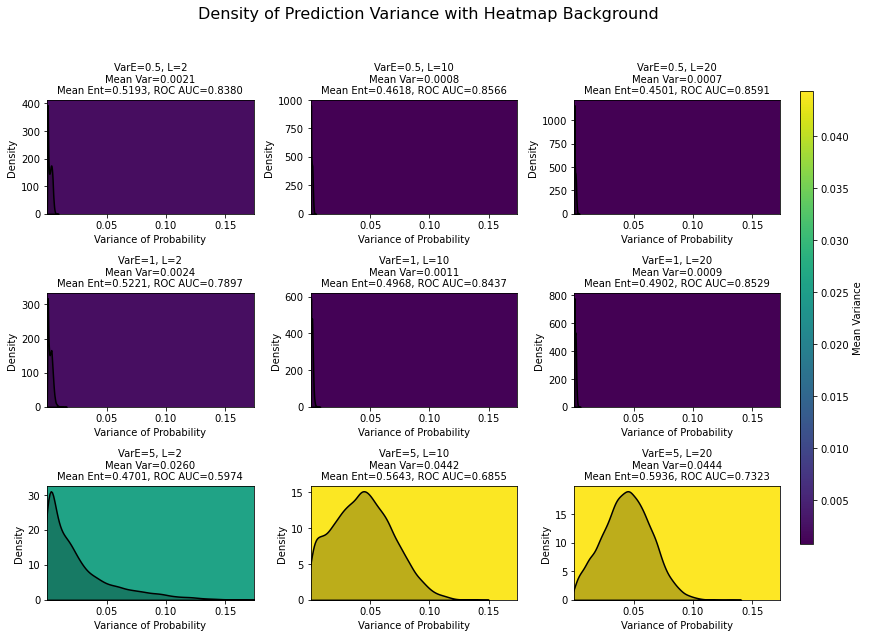

In [4]:
from sklearn.metrics import roc_auc_score
from scipy.stats import entropy as scipy_entropy
train_var_e = 1
test_var_es=[0.5,1,5]
train_l = 10
test_ls = [2,10,20]
num_data = 100000
beta_var = 0.4
pooling = "cls"
all_variances = {}  # (test_var_e, test_l) -> per-sample variances
mean_variances = np.zeros((len(test_var_es), len(test_ls)))  # for heatmap
mean_entropies = np.zeros((len(test_var_es), len(test_ls)))
mean_rocs = np.zeros((len(test_var_es), len(test_ls)))

for i, test_var_e in enumerate(test_var_es):
    for j, test_l in enumerate(test_ls):
        file_path = f'epi_model_tsf_ood/tsf_{pooling}_ss{num_data}_trainl{train_l}_testl{test_l}_train{train_var_e}_test{test_var_e}_beta_var{beta_var}.pkl'
        with open(file_path, 'rb') as f:
            pre_df = pickle.load(f)

        pred_array = pre_df.values.astype(np.float32)  
        sample_variances = np.var(pred_array, axis=1)
        all_variances[(test_var_e, test_l)] = sample_variances
        mean_variances[i, j] = np.mean(sample_variances)

        data_inf_len_test = generate_data(
            vi_dim=20, num_data=100000, max_num_emb=100,
            v=0, seed=42, length_vary=False,
            sample_cut=100000, len_cut=test_l,
            var_e=test_var_e, beta_var=beta_var,plot=False
        )
        _, X_test, _, y_test, *_ = data_inf_len_test

        mean_preds = pred_array.mean(axis=1)  

        eps = 1e-8  # 
        mean_entropy = -np.mean(mean_preds * np.log(mean_preds + eps) + (1 - mean_preds) * np.log(1 - mean_preds + eps))
        mean_entropies[i, j] = mean_entropy

        try:
            roc_auc = roc_auc_score(y_test, mean_preds)
        except ValueError:
            roc_auc = np.nan 
        mean_rocs[i, j] = roc_auc

import seaborn as sns
all_var_values = np.concatenate([v for v in all_variances.values()])
xmin, xmax = all_var_values.min(), all_var_values.max()

fig, axes = plt.subplots(len(test_var_es), len(test_ls), figsize=(4 * len(test_ls), 3 * len(test_var_es)))
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=np.min(mean_variances), vmax=np.max(mean_variances))

for i, test_var_e in enumerate(test_var_es):
    for j, test_l in enumerate(test_ls):
        ax = axes[i][j] if len(test_var_es) > 1 else axes[j]
        var_vec = all_variances[(test_var_e, test_l)]
        mean_var = mean_variances[i, j]
        mean_entropy = mean_entropies[i, j]
        mean_rocauc = mean_rocs[i, j]

        ax.set_facecolor(cmap(norm(mean_var)))

        sns.kdeplot(var_vec, ax=ax, fill=True, color='black', linewidth=1.5)

        ax.set_xlim(xmin, xmax)  

        ax.set_title(
            f"VarE={test_var_e}, L={test_l}\n"
            f"Mean Var={mean_var:.4f}\n"
            f"Mean Ent={mean_entropy:.4f}, ROC AUC={mean_rocauc:.4f}",
            fontsize=10
        )
        ax.set_xlabel("Variance of Probability")
        ax.set_ylabel("Density")

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cb.set_label('Mean Variance')

plt.suptitle("Density of Prediction Variance with Heatmap Background", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.show()

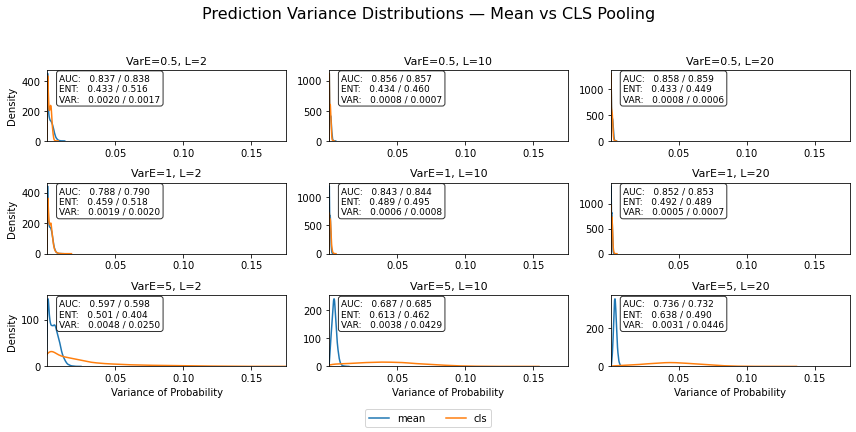

In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_auc_score

# ==== Experiment Config ====
poolings = ["mean", "cls"]
test_var_es = [0.5, 1, 5]
test_ls = [2, 10, 20]
train_var_e = 1
train_l = 10
num_data = 100000
beta_var = 0.4
noise_ratio = 0.5
vi_dim = 20
seed = 42
noise_mean = 2.0
noise_var = 1.5

# ==== Prepare Data ====
results = {}
all_var_values = []

for pooling in poolings:
    mean_vars = np.zeros((len(test_var_es), len(test_ls)))
    mean_ents = np.zeros((len(test_var_es), len(test_ls)))
    mean_rocs = np.zeros((len(test_var_es), len(test_ls)))
    variances = {}

    for i, test_var_e in enumerate(test_var_es):
        for j, test_l in enumerate(test_ls):
            file_path = f'epi_model_tsf_ood/tsf_{pooling}_ss{num_data}_trainl{train_l}_testl{test_l}_train{train_var_e}_test{test_var_e}_beta_var{beta_var}.pkl'
            with open(file_path, 'rb') as f:
                pre_df = pickle.load(f)
            pred_array = pre_df.values.astype(np.float32)
            sample_var = np.var(pred_array, axis=1)
            eps = 1e-8
            entropies = -pred_array * np.log(pred_array + eps) - (1 - pred_array) * np.log(1 - pred_array + eps)
            sample_entropy = np.mean(entropies, axis=1)
            entropy = np.mean(sample_entropy)

            _, _, _, y_test, *_ = generate_data(
                vi_dim=vi_dim,
                num_data=100000,
                max_num_emb=100,
                v=0,
                seed=seed,
                length_vary=False,
                sample_cut=100000,
                len_cut=test_l,
                var_e=test_var_e,
                beta_var=beta_var,
                plot=False
            )

            mean_vars[i, j] = np.mean(sample_var)
            mean_ents[i, j] = entropy
            mean_preds = np.mean(pred_array, axis=1)
            try:
                roc_auc = roc_auc_score(y_test, mean_preds)
            except:
                roc_auc = np.nan
            mean_rocs[i, j] = roc_auc
            variances[(test_var_e, test_l)] = sample_var
            all_var_values.append(sample_var)


    results[pooling] = {
        "mean_vars": mean_vars,
        "mean_ents": mean_ents,
        "mean_rocs": mean_rocs,
        "variances": variances
    }

# ==== Normalize for x-axis ====
all_var_values = np.concatenate(all_var_values)
xmin, xmax = all_var_values.min(), all_var_values.max()
colors = {'mean': '#1f77b4', 'cls': '#ff7f0e'}

# ==== Plot ====
fig, axes = plt.subplots(len(test_var_es), len(test_ls), figsize=(4 * len(test_ls), 2 * len(test_var_es)))

for i, test_var_e in enumerate(test_var_es):
    for j, test_l in enumerate(test_ls):
        ax = axes[i][j] if len(test_var_es) > 1 else axes[j]

        # Plot KDEs
        for pooling in poolings:
            var_vec = results[pooling]["variances"][(test_var_e, test_l)]
            sns.kdeplot(var_vec, ax=ax, fill=False, linewidth=1.5, color=colors[pooling], label=pooling)

        ax.set_xlim(xmin, xmax)

        # Collect metrics
        mv_mean = [results[p]["mean_vars"][i, j] for p in poolings]
        ent_mean = [results[p]["mean_ents"][i, j] for p in poolings]
        auc_mean = [results[p]["mean_rocs"][i, j] for p in poolings]

        # Add multi-line caption inside the plot
        caption = (
            f"AUC:   {auc_mean[0]:.3f} / {auc_mean[1]:.3f}\n"
            f"ENT:   {ent_mean[0]:.3f} / {ent_mean[1]:.3f}\n"
            f"VAR:   {mv_mean[0]:.4f} / {mv_mean[1]:.4f}"
        )
        ax.text(0.05, 0.95, caption, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

        if i == len(test_var_es) - 1:
            ax.set_xlabel("Variance of Probability")
        else:
            ax.set_xlabel("")
        if j == 0:
            ax.set_ylabel("Density")
        else:
            ax.set_ylabel("")
        ax.set_title(f"VarE={test_var_e}, L={test_l}", fontsize=11)

# Global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(poolings), fontsize=10)

plt.suptitle("Prediction Variance Distributions — Mean vs CLS Pooling", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

## Data with noise

Mean pooling

<ipython-input-5-1e9649d04125>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


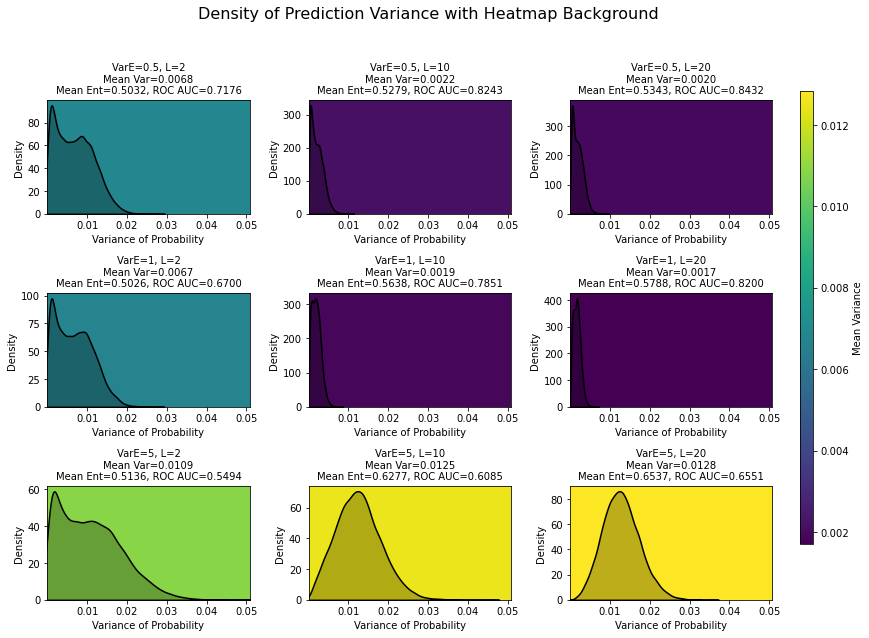

In [5]:
from sklearn.metrics import roc_auc_score
from scipy.stats import entropy as scipy_entropy
train_var_e = 1
test_var_es=[0.5,1,5]
train_l = 10
test_ls = [2,10,20]
num_data = 100000
beta_var = 0.4
pooling = "mean"
noise_ratio=0.5
all_variances = {}  # (test_var_e, test_l) -> per-sample variances
mean_variances = np.zeros((len(test_var_es), len(test_ls)))  # for heatmap
mean_entropies = np.zeros((len(test_var_es), len(test_ls)))
mean_rocs = np.zeros((len(test_var_es), len(test_ls)))

for i, test_var_e in enumerate(test_var_es):
    for j, test_l in enumerate(test_ls):
        file_path = f'epi_model_tsf_ood_noise/tsf_{pooling}_ss{num_data}_trainl{train_l}_testl{test_l}_train{train_var_e}_test{test_var_e}_beta_var{beta_var}_noiseratio{noise_ratio}.pkl'
        with open(file_path, 'rb') as f:
            pre_df = pickle.load(f)

        pred_array = pre_df.values.astype(np.float32)  
        sample_variances = np.var(pred_array, axis=1)
        all_variances[(test_var_e, test_l)] = sample_variances
        mean_variances[i, j] = np.mean(sample_variances)

        data_inf_len_test = generate_data(
            vi_dim=20, num_data=100000, max_num_emb=100,
            v=0, seed=42, length_vary=False,
            sample_cut=100000, len_cut=test_l,
            var_e=test_var_e, beta_var=beta_var,plot=False
        )
        _, X_test, _, y_test, *_ = data_inf_len_test

        mean_preds = pred_array.mean(axis=1)  

        eps = 1e-8  # 
        mean_entropy = -np.mean(mean_preds * np.log(mean_preds + eps) + (1 - mean_preds) * np.log(1 - mean_preds + eps))
        mean_entropies[i, j] = mean_entropy

        try:
            roc_auc = roc_auc_score(y_test, mean_preds)
        except ValueError:
            roc_auc = np.nan 
        mean_rocs[i, j] = roc_auc

import seaborn as sns
all_var_values = np.concatenate([v for v in all_variances.values()])
xmin, xmax = all_var_values.min(), all_var_values.max()

fig, axes = plt.subplots(len(test_var_es), len(test_ls), figsize=(4 * len(test_ls), 3 * len(test_var_es)))
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=np.min(mean_variances), vmax=np.max(mean_variances))

for i, test_var_e in enumerate(test_var_es):
    for j, test_l in enumerate(test_ls):
        ax = axes[i][j] if len(test_var_es) > 1 else axes[j]
        var_vec = all_variances[(test_var_e, test_l)]
        mean_var = mean_variances[i, j]
        mean_entropy = mean_entropies[i, j]
        mean_rocauc = mean_rocs[i, j]

        ax.set_facecolor(cmap(norm(mean_var)))

        sns.kdeplot(var_vec, ax=ax, fill=True, color='black', linewidth=1.5)

        ax.set_xlim(xmin, xmax)  # 👈 统一x轴范围

        ax.set_title(
            f"VarE={test_var_e}, L={test_l}\n"
            f"Mean Var={mean_var:.4f}\n"
            f"Mean Ent={mean_entropy:.4f}, ROC AUC={mean_rocauc:.4f}",
            fontsize=10
        )
        ax.set_xlabel("Variance of Probability")
        ax.set_ylabel("Density")

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cb.set_label('Mean Variance')

plt.suptitle("Density of Prediction Variance with Heatmap Background", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.show()

CLS

<ipython-input-4-312aa6973092>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


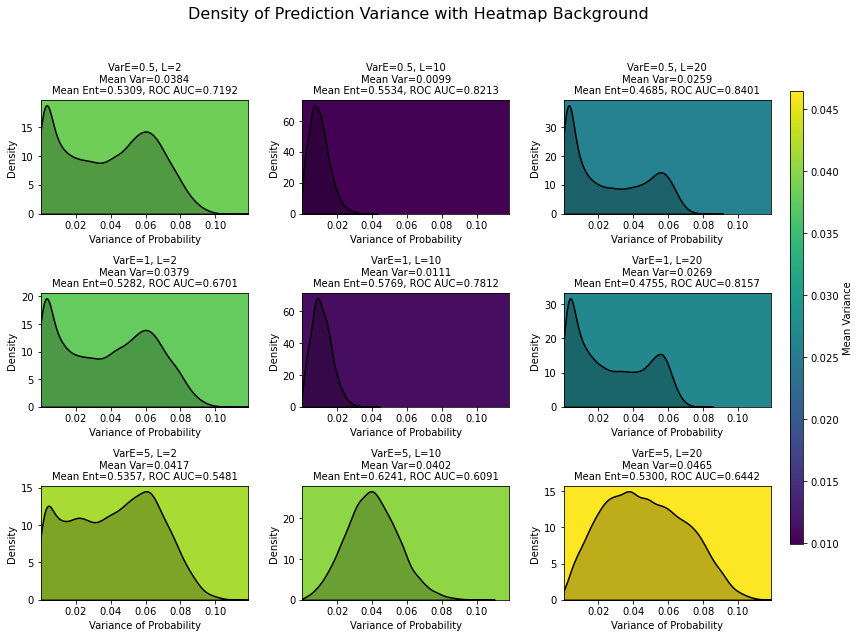

In [4]:
from sklearn.metrics import roc_auc_score
from scipy.stats import entropy as scipy_entropy
train_var_e = 1
test_var_es=[0.5,1,5]
train_l = 10
test_ls = [2,10,20]
num_data = 100000
beta_var = 0.4
pooling = "cls"
noise_ratio=0.5
all_variances = {}  # (test_var_e, test_l) -> per-sample variances
mean_variances = np.zeros((len(test_var_es), len(test_ls)))  # for heatmap
mean_entropies = np.zeros((len(test_var_es), len(test_ls)))
mean_rocs = np.zeros((len(test_var_es), len(test_ls)))

for i, test_var_e in enumerate(test_var_es):
    for j, test_l in enumerate(test_ls):
        file_path = f'epi_model_tsf_ood_noise/tsf_{pooling}_ss{num_data}_trainl{train_l}_testl{test_l}_train{train_var_e}_test{test_var_e}_beta_var{beta_var}_noiseratio{noise_ratio}.pkl'
        with open(file_path, 'rb') as f:
            pre_df = pickle.load(f)

        pred_array = pre_df.values.astype(np.float32)  
        sample_variances = np.var(pred_array, axis=1)
        all_variances[(test_var_e, test_l)] = sample_variances
        mean_variances[i, j] = np.mean(sample_variances)

        data_inf_len_test = generate_data(
            vi_dim=20, num_data=100000, max_num_emb=100,
            v=0, seed=42, length_vary=False,
            sample_cut=100000, len_cut=test_l,
            var_e=test_var_e, beta_var=beta_var,plot=False
        )
        _, X_test, _, y_test, *_ = data_inf_len_test

        mean_preds = pred_array.mean(axis=1)  

        eps = 1e-8  # 
        mean_entropy = -np.mean(mean_preds * np.log(mean_preds + eps) + (1 - mean_preds) * np.log(1 - mean_preds + eps))
        mean_entropies[i, j] = mean_entropy

        try:
            roc_auc = roc_auc_score(y_test, mean_preds)
        except ValueError:
            roc_auc = np.nan 
        mean_rocs[i, j] = roc_auc

import seaborn as sns
all_var_values = np.concatenate([v for v in all_variances.values()])
xmin, xmax = all_var_values.min(), all_var_values.max()

fig, axes = plt.subplots(len(test_var_es), len(test_ls), figsize=(4 * len(test_ls), 3 * len(test_var_es)))
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=np.min(mean_variances), vmax=np.max(mean_variances))

for i, test_var_e in enumerate(test_var_es):
    for j, test_l in enumerate(test_ls):
        ax = axes[i][j] if len(test_var_es) > 1 else axes[j]
        var_vec = all_variances[(test_var_e, test_l)]
        mean_var = mean_variances[i, j]
        mean_entropy = mean_entropies[i, j]
        mean_rocauc = mean_rocs[i, j]

        ax.set_facecolor(cmap(norm(mean_var)))

        sns.kdeplot(var_vec, ax=ax, fill=True, color='black', linewidth=1.5)

        ax.set_xlim(xmin, xmax)  # 👈 统一x轴范围

        ax.set_title(
            f"VarE={test_var_e}, L={test_l}\n"
            f"Mean Var={mean_var:.4f}\n"
            f"Mean Ent={mean_entropy:.4f}, ROC AUC={mean_rocauc:.4f}",
            fontsize=10
        )
        ax.set_xlabel("Variance of Probability")
        ax.set_ylabel("Density")

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cb.set_label('Mean Variance')

plt.suptitle("Density of Prediction Variance with Heatmap Background", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.show()

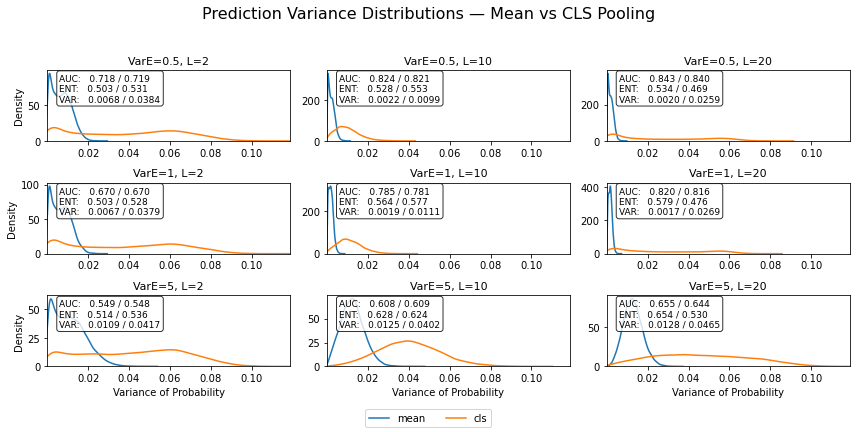

In [3]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_auc_score

# ==== Experiment Config ====
poolings = ["mean", "cls"]
test_var_es = [0.5, 1, 5]
test_ls = [2, 10, 20]
train_var_e = 1
train_l = 10
num_data = 100000
beta_var = 0.4
noise_ratio = 0.5
vi_dim = 20
seed = 42
noise_mean = 2.0
noise_var = 1.5

# ==== Prepare Data ====
results = {}
all_var_values = []

for pooling in poolings:
    mean_vars = np.zeros((len(test_var_es), len(test_ls)))
    mean_ents = np.zeros((len(test_var_es), len(test_ls)))
    mean_rocs = np.zeros((len(test_var_es), len(test_ls)))
    variances = {}

    for i, test_var_e in enumerate(test_var_es):
        for j, test_l in enumerate(test_ls):
            file_path = f'epi_model_tsf_ood_noise/tsf_{pooling}_ss{num_data}_trainl{train_l}_testl{test_l}_train{train_var_e}_test{test_var_e}_beta_var{beta_var}_noiseratio{noise_ratio}.pkl'
            with open(file_path, 'rb') as f:
                pre_df = pickle.load(f)
            pred_array = pre_df.values.astype(np.float32)
            sample_var = np.var(pred_array, axis=1)
            mean_preds = np.mean(pred_array, axis=1)

            _, _, _, y_test, *_ = generate_data_with_noise(
                vi_dim=vi_dim,
                num_data=100000,
                max_num_emb=100,
                v=0,
                seed=seed,
                length_vary=False,
                sample_cut=100000,
                len_cut=test_l,
                var_e=test_var_e,
                beta_var=beta_var,
                noise_ratio=noise_ratio,
                noise_mean=noise_mean,
                noise_var=noise_var,
                plot=False
            )

            mean_vars[i, j] = np.mean(sample_var)
            eps = 1e-8
            entropy = -np.mean(mean_preds * np.log(mean_preds + eps) + (1 - mean_preds) * np.log(1 - mean_preds + eps))
            mean_ents[i, j] = entropy
            try:
                roc_auc = roc_auc_score(y_test, mean_preds)
            except:
                roc_auc = np.nan
            mean_rocs[i, j] = roc_auc
            variances[(test_var_e, test_l)] = sample_var
            all_var_values.append(sample_var)

    results[pooling] = {
        "mean_vars": mean_vars,
        "mean_ents": mean_ents,
        "mean_rocs": mean_rocs,
        "variances": variances
    }

# ==== Normalize for x-axis ====
all_var_values = np.concatenate(all_var_values)
xmin, xmax = all_var_values.min(), all_var_values.max()
colors = {'mean': '#1f77b4', 'cls': '#ff7f0e'}

# ==== Plot ====
fig, axes = plt.subplots(len(test_var_es), len(test_ls), figsize=(4 * len(test_ls), 2 * len(test_var_es)))

for i, test_var_e in enumerate(test_var_es):
    for j, test_l in enumerate(test_ls):
        ax = axes[i][j] if len(test_var_es) > 1 else axes[j]

        # Plot KDEs
        for pooling in poolings:
            var_vec = results[pooling]["variances"][(test_var_e, test_l)]
            sns.kdeplot(var_vec, ax=ax, fill=False, linewidth=1.5, color=colors[pooling], label=pooling)

        ax.set_xlim(xmin, xmax)

        # Collect metrics
        mv_mean = [results[p]["mean_vars"][i, j] for p in poolings]
        ent_mean = [results[p]["mean_ents"][i, j] for p in poolings]
        auc_mean = [results[p]["mean_rocs"][i, j] for p in poolings]

        # Add multi-line caption inside the plot
        caption = (
            f"AUC:   {auc_mean[0]:.3f} / {auc_mean[1]:.3f}\n"
            f"ENT:   {ent_mean[0]:.3f} / {ent_mean[1]:.3f}\n"
            f"VAR:   {mv_mean[0]:.4f} / {mv_mean[1]:.4f}"
        )
        ax.text(0.05, 0.95, caption, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

        if i == len(test_var_es) - 1:
            ax.set_xlabel("Variance of Probability")
        else:
            ax.set_xlabel("")
        if j == 0:
            ax.set_ylabel("Density")
        else:
            ax.set_ylabel("")
        ax.set_title(f"VarE={test_var_e}, L={test_l}", fontsize=11)

# Global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(poolings), fontsize=10)

plt.suptitle("Prediction Variance Distributions — Mean vs CLS Pooling", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# MC dropout

In [6]:
# MC Dropout parameters
mc_dropout_seed = 1
mc_dropout_pooling = 'cls'  # Options: 'cls', 'mean', 'mean_no_pad', 'mask_np_mp'
mc_dropout_learning_rate = 1e-3
mc_dropout_epochs = 50
mc_dropout_n_trainings = 5  # Number of models
mc_dropout_mc_samples = 10  # Number of Monte Carlo samples
mc_dropout_dropout_rate = 0.5

# Transformer configurations for MC Dropout
mc_dropout_configs = [
    (1, 1),
    (1, 2),
    (1, 3),
    (2, 1),
    (4, 1)
]

mc_dropout_result = []

for heads, layers in mc_dropout_configs:
    print(f"\nTraining MC Dropout models with {heads} heads and {layers} layers.")
    n_samples = len(y_test)
    predictions_df = pd.DataFrame(index=range(n_samples), columns=range(mc_dropout_n_trainings))
    subres = []

    for i in tqdm(range(mc_dropout_n_trainings), desc=f"Config {heads}h{layers}l"):
        print(f"\nTraining Model {i+1}/{mc_dropout_n_trainings} for config {heads}h{layers}l.")

        # Initialize model
        model = TransformerWithMCDropout(
            embedding_size=embedding_size,
            nhead=heads,
            dim_feedforward=512,
            num_layers=layers,
            num_classes=2,
            pooling=mc_dropout_pooling,
            dropout=mc_dropout_dropout_rate
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=mc_dropout_learning_rate)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
        early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path=f'best_model_mc_dropout_{heads}h{layers}l_model{i}.pt')

        # Train the model
        trained_model = train_predict(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            epochs=mc_dropout_epochs,
            scheduler=scheduler,
            early_stopping=early_stopping,
            device=device
        )

        # Perform MC Dropout predictions
        predictions = []
        trained_model.eval()
        trained_model.enable_dropout()  # Enable dropout during inference

        for _ in range(mc_dropout_mc_samples):
            all_probs = []
            with torch.no_grad():
                for batch in val_loader:
                    test_inputs, val_padding_mask, _ = batch
                    test_inputs = test_inputs.float().to(device)
                    val_padding_mask = val_padding_mask.to(device)

                    outputs = trained_model(test_inputs, src_key_padding_mask=val_padding_mask)
                    probs = F.softmax(outputs, dim=1)
                    all_probs.append(probs.cpu().numpy()[:, 1])

            probs_mc = np.concatenate(all_probs)
            predictions.append(probs_mc)

        predictions = np.array(predictions)
        predictions_df[i] = predictions.mean(axis=0)
        predicted_classes = (predictions.mean(axis=0) >= 0.5).astype(int)
        accuracy = np.mean(predicted_classes == y_test)
        print(f"Model {i+1}/{mc_dropout_n_trainings}, Test Accuracy: {accuracy:.4f}")

        # Clean up
        del model
        torch.cuda.empty_cache()

    mc_dropout_result.append(predictions_df)



Training MC Dropout models with 1 heads and 1 layers.


Config 1h1l:   0%|          | 0/5 [00:00<?, ?it/s]


Training Model 1/5 for config 1h1l.
Early stopping triggered.


Config 1h1l:  20%|██        | 1/5 [00:05<00:20,  5.16s/it]

Model 1/5, Test Accuracy: 0.7187

Training Model 2/5 for config 1h1l.


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fa5e34647c0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Early stopping triggered.


Config 1h1l:  40%|████      | 2/5 [00:11<00:17,  5.81s/it]

Model 2/5, Test Accuracy: 0.7290

Training Model 3/5 for config 1h1l.
Early stopping triggered.


Config 1h1l:  60%|██████    | 3/5 [00:16<00:10,  5.44s/it]

Model 3/5, Test Accuracy: 0.7137

Training Model 4/5 for config 1h1l.
Early stopping triggered.


Config 1h1l:  80%|████████  | 4/5 [00:24<00:06,  6.39s/it]

Model 4/5, Test Accuracy: 0.7240

Training Model 5/5 for config 1h1l.
Early stopping triggered.


Config 1h1l: 100%|██████████| 5/5 [00:29<00:00,  5.92s/it]


Model 5/5, Test Accuracy: 0.7187

Training MC Dropout models with 1 heads and 2 layers.


Config 1h2l:   0%|          | 0/5 [00:00<?, ?it/s]


Training Model 1/5 for config 1h2l.
Early stopping triggered.


Config 1h2l:  20%|██        | 1/5 [00:05<00:22,  5.67s/it]

Model 1/5, Test Accuracy: 0.7087

Training Model 2/5 for config 1h2l.
Early stopping triggered.


Config 1h2l:  40%|████      | 2/5 [00:11<00:17,  5.75s/it]

Model 2/5, Test Accuracy: 0.7093

Training Model 3/5 for config 1h2l.
Early stopping triggered.


Config 1h2l:  60%|██████    | 3/5 [00:20<00:14,  7.47s/it]

Model 3/5, Test Accuracy: 0.7320

Training Model 4/5 for config 1h2l.
Early stopping triggered.


Config 1h2l:  80%|████████  | 4/5 [00:26<00:06,  6.63s/it]

Model 4/5, Test Accuracy: 0.6997

Training Model 5/5 for config 1h2l.
Early stopping triggered.


Config 1h2l: 100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


Model 5/5, Test Accuracy: 0.7300

Training MC Dropout models with 1 heads and 3 layers.


Config 1h3l:   0%|          | 0/5 [00:00<?, ?it/s]


Training Model 1/5 for config 1h3l.
Early stopping triggered.


Config 1h3l:  20%|██        | 1/5 [00:08<00:32,  8.19s/it]

Model 1/5, Test Accuracy: 0.7313

Training Model 2/5 for config 1h3l.
Early stopping triggered.


Config 1h3l:  40%|████      | 2/5 [00:15<00:23,  7.89s/it]

Model 2/5, Test Accuracy: 0.7180

Training Model 3/5 for config 1h3l.
Early stopping triggered.


Config 1h3l:  60%|██████    | 3/5 [00:25<00:17,  8.67s/it]

Model 3/5, Test Accuracy: 0.7270

Training Model 4/5 for config 1h3l.


Config 1h3l:  60%|██████    | 3/5 [00:33<00:22, 11.27s/it]

Early stopping triggered.


KeyboardInterrupt: 

# Evidential Deep Learning (EDL) Training

In [5]:
# EDL Training parameters
edl_seed = 1
edl_pooling = 'cls'  # Options: 'cls', 'mean', 'mean_no_pad', 'mask_np_mp'
edl_learning_rate = 1e-3
edl_epochs = 50
edl_n_trainings = 5  # Number of models
annealing_step = 10  # For loss function

# Transformer configurations for EDL
edl_configs = [
    (1, 1),
    (1, 2),
    (1, 3),
    (2, 1),
    (4, 1)
]

edl_result = []

for heads, layers in edl_configs:
    print(f"\nTraining EDL models with {heads} heads and {layers} layers.")
    n_samples = len(y_test)
    predictions_df = pd.DataFrame(index=range(n_samples), columns=range(edl_n_trainings))
    uncertainty_df = pd.DataFrame(index=range(n_samples), columns=range(edl_n_trainings))
    evidence_df = pd.DataFrame(index=range(n_samples), columns=range(edl_n_trainings))

    for i in tqdm(range(edl_n_trainings), desc=f"Config {heads}h{layers}l"):
        print(f"\nTraining Model {i+1}/{edl_n_trainings} for config {heads}h{layers}l.")

        # Initialize model
        model = TransformerWithPoolingEDL(
            embedding_size=embedding_size,
            nhead=heads,
            dim_feedforward=512,
            num_layers=layers,
            num_classes=2,
            pooling=edl_pooling,
            dropout=0.1
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=edl_learning_rate)
        criterion = mse_loss  # Custom loss function for EDL
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
        early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path=f'best_model_edl_{heads}h{layers}l_model{i}.pt')
        l2e=exp_evidence
        trained_model = train_predict_edl(
                model=model,
                train_loader=train_loader, 
                l2e=l2e,  
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=edl_epochs,
                scheduler=scheduler,
                early_stopping=early_stopping,
                device=device
            )


        # Evaluate the model
        all_probs = []
        all_uncertainties = []
        all_evidences = []
        trained_model.eval()

        with torch.no_grad():
            for batch in val_loader:
                test_inputs, val_padding_mask, _ = batch
                test_inputs = test_inputs.float().to(device)
                val_padding_mask = val_padding_mask.to(device)

                outputs = trained_model(test_inputs, src_key_padding_mask=val_padding_mask)

                # Convert logits to evidence and calculate alpha
                evidence = F.relu(outputs)  # logits2evidence function
                alpha = evidence + 1

                # Calculate uncertainty and probabilities
                uncertainty, prob = uncertainty_and_probabilities(alpha)

                # Aggregate results
                all_probs.append(prob.cpu().numpy()[:, 1])
                all_uncertainties.append(uncertainty.cpu().numpy().squeeze())
                all_evidences.append(np.sum(evidence.cpu().numpy(), axis=1))

        probabilities = np.concatenate(all_probs)
        uncertainties = np.concatenate(all_uncertainties)
        evidences = np.concatenate(all_evidences, axis=0)

        predictions_df[i] = probabilities
        uncertainty_df[i] = uncertainties
        evidence_df[i] = evidences
        predicted_classes = (probabilities >= 0.5).astype(int)
        accuracy = np.mean(predicted_classes == y_test)
        print(f"Model {i+1}/{edl_n_trainings}, Test Accuracy: {accuracy:.4f}")

        # Clean up
        del model
        torch.cuda.empty_cache()

    edl_result.append([predictions_df, uncertainty_df, evidence_df])



Training EDL models with 1 heads and 1 layers.


Config 1h1l:   0%|          | 0/5 [00:00<?, ?it/s]


Training Model 1/5 for config 1h1l.
Epoch 1/50, Training Loss: 0.5871, Validation Loss: 1.0528
Epoch 2/50, Training Loss: 0.5626, Validation Loss: 1.2590
Epoch 3/50, Training Loss: 0.5779, Validation Loss: 0.8369
Epoch 4/50, Training Loss: 0.5310, Validation Loss: 0.6188
Epoch 5/50, Training Loss: 0.5037, Validation Loss: 0.5675
Epoch 6/50, Training Loss: 0.4968, Validation Loss: 0.5617
Epoch 7/50, Training Loss: 0.4964, Validation Loss: 0.5544
Epoch 8/50, Training Loss: 0.5025, Validation Loss: 0.5432
Epoch 9/50, Training Loss: 0.5049, Validation Loss: 0.5367
Epoch 10/50, Training Loss: 0.5096, Validation Loss: 0.5334
Epoch 11/50, Training Loss: 0.5133, Validation Loss: 0.5329
Epoch 12/50, Training Loss: 0.5117, Validation Loss: 0.5310
Epoch 13/50, Training Loss: 0.5109, Validation Loss: 0.5313
Epoch 14/50, Training Loss: 0.5098, Validation Loss: 0.5319
Epoch 15/50, Training Loss: 0.5082, Validation Loss: 0.5303
Epoch 16/50, Training Loss: 0.5069, Validation Loss: 0.5301
Epoch 17/50,

Config 1h1l:  20%|██        | 1/5 [00:07<00:28,  7.08s/it]

Model 1/5, Test Accuracy: 0.6873

Training Model 2/5 for config 1h1l.
Epoch 1/50, Training Loss: 0.6054, Validation Loss: 0.9739
Epoch 2/50, Training Loss: 0.5853, Validation Loss: 1.1476
Epoch 3/50, Training Loss: 0.6001, Validation Loss: 0.8129
Epoch 4/50, Training Loss: 0.5605, Validation Loss: 0.6233
Epoch 5/50, Training Loss: 0.5269, Validation Loss: 0.5746
Epoch 6/50, Training Loss: 0.5093, Validation Loss: 0.5731
Epoch 7/50, Training Loss: 0.5061, Validation Loss: 0.5594
Epoch 8/50, Training Loss: 0.5066, Validation Loss: 0.5421
Epoch 9/50, Training Loss: 0.5096, Validation Loss: 0.5392
Epoch 10/50, Training Loss: 0.5105, Validation Loss: 0.5389
Epoch 11/50, Training Loss: 0.5141, Validation Loss: 0.5334
Epoch 12/50, Training Loss: 0.5123, Validation Loss: 0.5318
Epoch 13/50, Training Loss: 0.5096, Validation Loss: 0.5327
Epoch 14/50, Training Loss: 0.5090, Validation Loss: 0.5317
Epoch 15/50, Training Loss: 0.5067, Validation Loss: 0.5306
Epoch 16/50, Training Loss: 0.5052, Val

Config 1h1l:  40%|████      | 2/5 [00:19<00:30, 10.23s/it]

Epoch 28/50, Training Loss: 0.4777, Validation Loss: 0.5271
Early stopping triggered.
Model 2/5, Test Accuracy: 0.6883

Training Model 3/5 for config 1h1l.
Epoch 1/50, Training Loss: 0.5829, Validation Loss: 1.3014
Epoch 2/50, Training Loss: 0.5807, Validation Loss: 1.3857
Epoch 3/50, Training Loss: 0.5999, Validation Loss: 0.8336
Epoch 4/50, Training Loss: 0.5423, Validation Loss: 0.6137
Epoch 5/50, Training Loss: 0.5133, Validation Loss: 0.5702
Epoch 6/50, Training Loss: 0.5021, Validation Loss: 0.5659


Config 1h1l:  40%|████      | 2/5 [00:22<00:33, 11.17s/it]


KeyboardInterrupt: 

# Result loading

In [ ]:
# Create model directory if it doesn't exist
model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)

# Save Deep Ensemble results
deep_ensemble_path = os.path.join(model_dir, f'deep_ensemble_seed{deep_ensemble_seed}.pkl')
with open(deep_ensemble_path, 'wb') as f:
    pickle.dump(deep_ensemble_result, f)
print(f"Deep Ensemble results saved to {deep_ensemble_path}")

# Save MC Dropout results
mc_dropout_path = os.path.join(model_dir, f'mc_dropout_seed{mc_dropout_seed}.pkl')
with open(mc_dropout_path, 'wb') as f:
    pickle.dump(mc_dropout_result, f)
print(f"MC Dropout results saved to {mc_dropout_path}")

# Save EDL results
edl_path = os.path.join(model_dir, f'edl_seed{edl_seed}.pkl')
with open(edl_path, 'wb') as f:
    pickle.dump(edl_result, f)
print(f"EDL results saved to {edl_path}")


In [ ]:
# Function to load results
def load_results(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Load Deep Ensemble results
deep_ensemble_loaded = load_results(deep_ensemble_path)

# Load MC Dropout results
mc_dropout_loaded = load_results(mc_dropout_path)

# Load EDL results
edl_loaded = load_results(edl_path)